In [1]:
%%html
<style>
table {float:left}
a {text-decoration:none!important; color:black}
a:hover {color:#b21c1c}
</style>
<script>
code_show=false;
function code_toggle(){
    if(code_show) {
        $('div.cell.code_cell.rendered.selected div.input').hide();
        $('.prompt').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
        $('.prompt').show();
    }
    code_show=!code_show;
}
function initialize(){
    document.body.style.fontFamily='Palatino';
    var output=$('.output_subarea.output_text.output_stream.output_stdout');
    $.merge(output,$('.output_subarea.output_text.output_result'));
    for(var i=0;i<output.length;i++)for(var j=0;j<output[i].children.length;j++)
        output[i].children[j].style.fontFamily='Palatino';
    code_toggle();
}
$(document).ready(initialize);
</script>
Click <a href="javascript:code_toggle()">here</a> to toggle.

<h1 style='text-align:center'>Hybrid Sentiment-Momentum Strategy in Cryptocurrency Market</h1>


<br>
<center>
<b>Yang (Allen) Wang</b> <i>(yangallenwang)</i><br>
<b>Huijie (Cynthia) Ren</b> <i>(cynthiaren)</i><br>
<b>Minghao (Krystal) Zhang</b> <i>(krystalzhang)</i><br>
</center>

This is an exploratory research trying to implement a simple yet robust sentiment analysis mechanism in the cryptocurrency market. We call it a hybrid sentiment-momentum strategy as it applies context analysis (or more specifically, word analysis) into traditional momentum strategies and adjusts position automatically over time using both factors. The hybrid strategy is implemented with backtesing period from Dec. 17th 2017 to May 2nd 2019. It yields cumulative return of 229% and a remarkable Sharpe ratio of 2.68 with acceptable maximum drawdown in out-of-sample backtest, which is a huge improvement from classical momentum strategies in our analysis.

## Table of Contents

- [**Introduction**](#intro)<a id='introback'></a>
- [**Data**](#dat)<a id='datback'></a>
    - [Data Crawling](#datc)<a id='datcback'></a>
    - [Data Preparation](#datp)<a id='datpback'></a>
- [**The Hybrid Model**](#mod)<a id='modback'></a>
    - [Model Construction](#modc)<a id='modcback'></a>
    - [Backtesting Results](#modb)<a id='modbback'></a>
    - [Model Sensitivity to Parameters](#sens)<a id='sensback'></a>
    - [Risk Management](#risk)<a id='riskback'></a>
- [**Conclusion**](#con)<a id='conback'></a>
- [**References**](#ref)<a id='refback'></a>
- [**Appendix**](#app)<a id='appback'></a>
    
<br><hr width=80% margin=auto style='border: 1px solid #ccc'><br>

## Introduction [↩](#introback)<a id='intro'></a>

Cryptocurrency has been a hot topic ever since the creation of Bitcoin in 2009. Unlike stocks which are backed by real companies, cryptocurrency has no intrinsic value, causing its price to be heavily reliant on market information. The decentralization of exchanges, the inconsistency of prices, the lack of tangible entity and assets all present serious analytics challenges that are difficult to solve with traditional tools. Therefore, we want to introduce news data into our strategy.


There are many reasons to believe that momentum strategy will perform well in this market. Compared to other markets, there are fewer participants in the cryptocurrency market; thus, information is both diffused and acted on slowly. In addition, a smaller number of participants leads to a lack of liquidity, forcing large investors to spread out transactions over time. Last but not least, the limited information source makes the decision of investors largely dependent on recent performance, which further drives the herd mentality. However, there are no less reasons to think that momentum strategy will fail. We need something else to help us decide when we should use momentum strategy and when we may want to go opposite. So we go one step further and develop a new strategy that we call hybrid sentiment-momentum strategy.


On the other hand, the cryptocurrency market is mostly driven by the overall investors' fanaticism, which suggests that momentum strategy would perform extremely well when this market is optimistic and bullish. However, when fanaticism is dampened by negative news, people go back to a more rational and conservative investing style, driving a momentum reversal strategy to gain.


In the following sections, we showcase our hybrid sentiment-momentum strategy step by step. First of all, we introduce how we use web crawling to get news data, coin prices and market capitalization and how we process them. After that, we illustrate our model construction and the underlying mathematical support. We then present our evaluation on strategy performance through comparing it with benchmark strategies including buy-and-hold, momentum and momentum reversal. Before wrapping up with our conclusions, we demonstrate our analysis on model sensitivity to multiple parameters.


## Data [↩](#datback)<a id='dat'></a>

In this section, we are going to discuss our source of data as well as how we prepare our data for the sentiment model.

In [2]:
import os
import warnings
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import product
import matplotlib.pyplot as plt
from scipy.stats import multinomial
from scipy.optimize import minimize
from IPython.display import display, HTML, Image
from wordcloud import WordCloud, STOPWORDS
from collections import Counter, namedtuple
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
matplotlib.font_manager._rebuild()
np.set_printoptions(linewidth=200, threshold=100, floatmode='fixed')
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Palatino'
plt.rcParams['axes.facecolor'] = '#000000'
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['figure.dpi'] = 150
pd.set_option('max_row', 10)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)
warnings.filterwarnings('ignore')

### Data Crawling [↩](#datcback)<a id='datc'></a>

**News Data**

We crawl all posts from [CoinDesk](http://www.coindesk.com). The crawling scripts are included in [Appendix A](#aa)<a id='aaback'></a>. We have news data from 2013-04-15 to 2019-05-02 (latest by the time of drafting). Entries are `title`, `abstract` and `contents`.

In [3]:
df = pd.read_csv('data/posts.csv', index_col=0)
df.index = pd.to_datetime(df.index).date
display(HTML(df.to_html(max_rows=10)))

**EOD Price & Market Cap Data**

Also, we crawl the [CoinMarketCap](https://coinmarketcap.com) for historical EOD data of over 10 major coins. Only daily close prices and market caps are kept. See [Appendix B](#ab)<a id='abback'></a> for codes. Cryptocurrency market is 24/7, for the purpose of this research, we define daily close price as the price at 24:00:00 UTC.

### Data Preparation [↩](#datpback)<a id='datp'></a>

**Step 0**: Group up post (news) data by dates.

In [4]:
df_eod = df.copy()
df_eod['date'] = pd.to_datetime(df_eod.index).date
g = df_eod.groupby('date')
title = g.title.apply(' '.join)
abstract = g.abstract.apply(' '.join)
content = g.content.apply(lambda x: '\n\n'.join(map(str, x.values)))
df_eod = pd.concat([title, abstract, content], axis=1)
df_eod.index = pd.to_datetime(df_eod.index)
df_eod.index.name = None
display(HTML(df_eod.to_html(max_rows=10)))

In [5]:
print(df_eod.iloc[0].content)

Researchers at Johns Hopkins University are proposing a cryptographic extension to bitcoin that could enable fully anonymous transactions on the network. The extension, called Zerocoin, works – as NewScientist explains it – by “allowing bitcoin users to leave their coins floating on the network for someone else to redeem, on the condition that they can redeem the same amount of bitcoin, similarly left floating on the network, at an arbitrary time in the future.”


**Step 1**: Get everything in its lowercase (if possible).

In [6]:
df_eod.title = df_eod.title.str.lower()
df_eod.abstract = df_eod.abstract.str.lower()
df_eod.content = df_eod.content.str.lower()
display(HTML(df_eod.to_html(max_rows=10)))

In [7]:
print(df_eod.iloc[0].content)

researchers at johns hopkins university are proposing a cryptographic extension to bitcoin that could enable fully anonymous transactions on the network. the extension, called zerocoin, works – as newscientist explains it – by “allowing bitcoin users to leave their coins floating on the network for someone else to redeem, on the condition that they can redeem the same amount of bitcoin, similarly left floating on the network, at an arbitrary time in the future.”


**Step 2**: Remove trivial abbreviations starting with `'` e.g. `'s`, `'ll`. Join all `\n` (paragraphs).


In [8]:
remove_abbr = lambda x: ' '.join([_.split('’')[0] for _ in x.split()])
df_eod = df_eod.applymap(remove_abbr)
display(HTML(df_eod.to_html(max_rows=10)))

In [9]:
print(df_eod.iloc[0].content)

researchers at johns hopkins university are proposing a cryptographic extension to bitcoin that could enable fully anonymous transactions on the network. the extension, called zerocoin, works – as newscientist explains it – by “allowing bitcoin users to leave their coins floating on the network for someone else to redeem, on the condition that they can redeem the same amount of bitcoin, similarly left floating on the network, at an arbitrary time in the future.”


**Step 3**: Keep only alphabetical symbols.

In [10]:
alph_space = lambda x: (ord('a') <= ord(x) <= ord('z')) or x == ' '
keep_alph = lambda x: ''.join(filter(alph_space, x))
df_eod = df_eod.applymap(keep_alph)
display(HTML(df_eod.to_html(max_rows=10)))

In [11]:
print(df_eod.iloc[0].content)

researchers at johns hopkins university are proposing a cryptographic extension to bitcoin that could enable fully anonymous transactions on the network the extension called zerocoin works  as newscientist explains it  by allowing bitcoin users to leave their coins floating on the network for someone else to redeem on the condition that they can redeem the same amount of bitcoin similarly left floating on the network at an arbitrary time in the future


**Step 4**: Remove all prepositions and other auxiliary words (aka "stop words" in NLP).

In [12]:
replace_stop_words = lambda x: ' '.join(_ for _ in x.split() if _ not in STOPWORDS)    
df_eod = df_eod.applymap(replace_stop_words)
display(HTML(df_eod.to_html(max_rows=10)))

In [13]:
print(df_eod.iloc[0].content)

researchers johns hopkins university proposing cryptographic extension bitcoin enable fully anonymous transactions network extension called zerocoin works newscientist explains allowing bitcoin users leave coins floating network someone redeem condition redeem amount bitcoin similarly left floating network arbitrary time future


**Step 5**: Convert dataframe entries into lists (or "bags") of words

In [14]:
df_eod = df_eod.applymap(str.split).applymap(sorted)
display(HTML(df_eod.to_html(max_rows=10)))

In [15]:
print(df_eod.iloc[0].content)

['allowing', 'amount', 'anonymous', 'arbitrary', 'bitcoin', 'bitcoin', 'bitcoin', 'called', 'coins', 'condition', 'cryptographic', 'enable', 'explains', 'extension', 'extension', 'floating', 'floating', 'fully', 'future', 'hopkins', 'johns', 'leave', 'left', 'network', 'network', 'network', 'newscientist', 'proposing', 'redeem', 'redeem', 'researchers', 'similarly', 'someone', 'time', 'transactions', 'university', 'users', 'works', 'zerocoin']


## The Hybrid Model  [↩](#modback)<a id='mod'></a>

In this part we'll introduce and implement the so-called hybrid model. We mainly follow the algorithm introduced in [Ke, Kelly and Xiu (2019)](#kkx2019)<a id='kkx2019back'></a>. To keep consistency, we use the same notations as used in the paper. In their paper, the underlying assets are stocks; and news data for stocks, unlike them for cryptocurrency, are abundant. To tailor the model without compromising the virtues of it, we keep the algorithm of the model but modify the definitions slightly. In the paper, $p$ is defined as the sentiment score of an article; in our research, we define $p$ to be the sentiment score of all the articles in a day. 
$\bs{O}^+$ and $\bs{O}^-$ are the distributions of the positive and negative sentiment topics respectively in the paper. We instead use them to represent the positive and negative sentiment topics in a day.

First let's take a look at the price data.

In [16]:
price = pd.read_csv('data/price.csv', index_col=0)
price.index = pd.to_datetime(price.index)
display(HTML(price.to_html(max_rows=10)))

And below is the market cap data.

In [17]:
mkcap = pd.read_csv('data/mkcap.csv', index_col=0)
mkcap.index = pd.to_datetime(mkcap.index)
display(HTML(mkcap.to_html(max_rows=10, float_format='%.4g')))

### Model Construction  [↩](#modcback)<a id='modc'></a>
Now we construct the momentum strategy with $n=3$ coins for both long and short sides, and a look-back window of $d=60$ days to determine the best- and worst-performing coins. This type of classical strategies was popularized  before Richard Donchian, i.e. mid 20th century, and got rather prevalent around 2000 ([Antonacci, 2014](#a2014)<a id='a2014back'></a>). Due to the diminishing market cap of some coins, we limit our momentum strategy to hold only top 10 coins considering market caps. For more detailed analysis on the efficiency of momentum strategies in the cryptocurrency market, see [Rohrbach, Suremann & Osterrieder (2017)](#rso2017)<a id='rso2017back'></a>.

The selected coins in the long and short positions are listed below (training part only), together with a histogram illustrating the empirical distribution of our momentum strategy. The table below the figure, which contains three entries, `words` (list of words on that day), `r` (momentum return) and `p` (rank score of `r`), is the result of our preliminary data preparation (training part only).

Benchmark strategy has mean return 0.30% with std 0.12


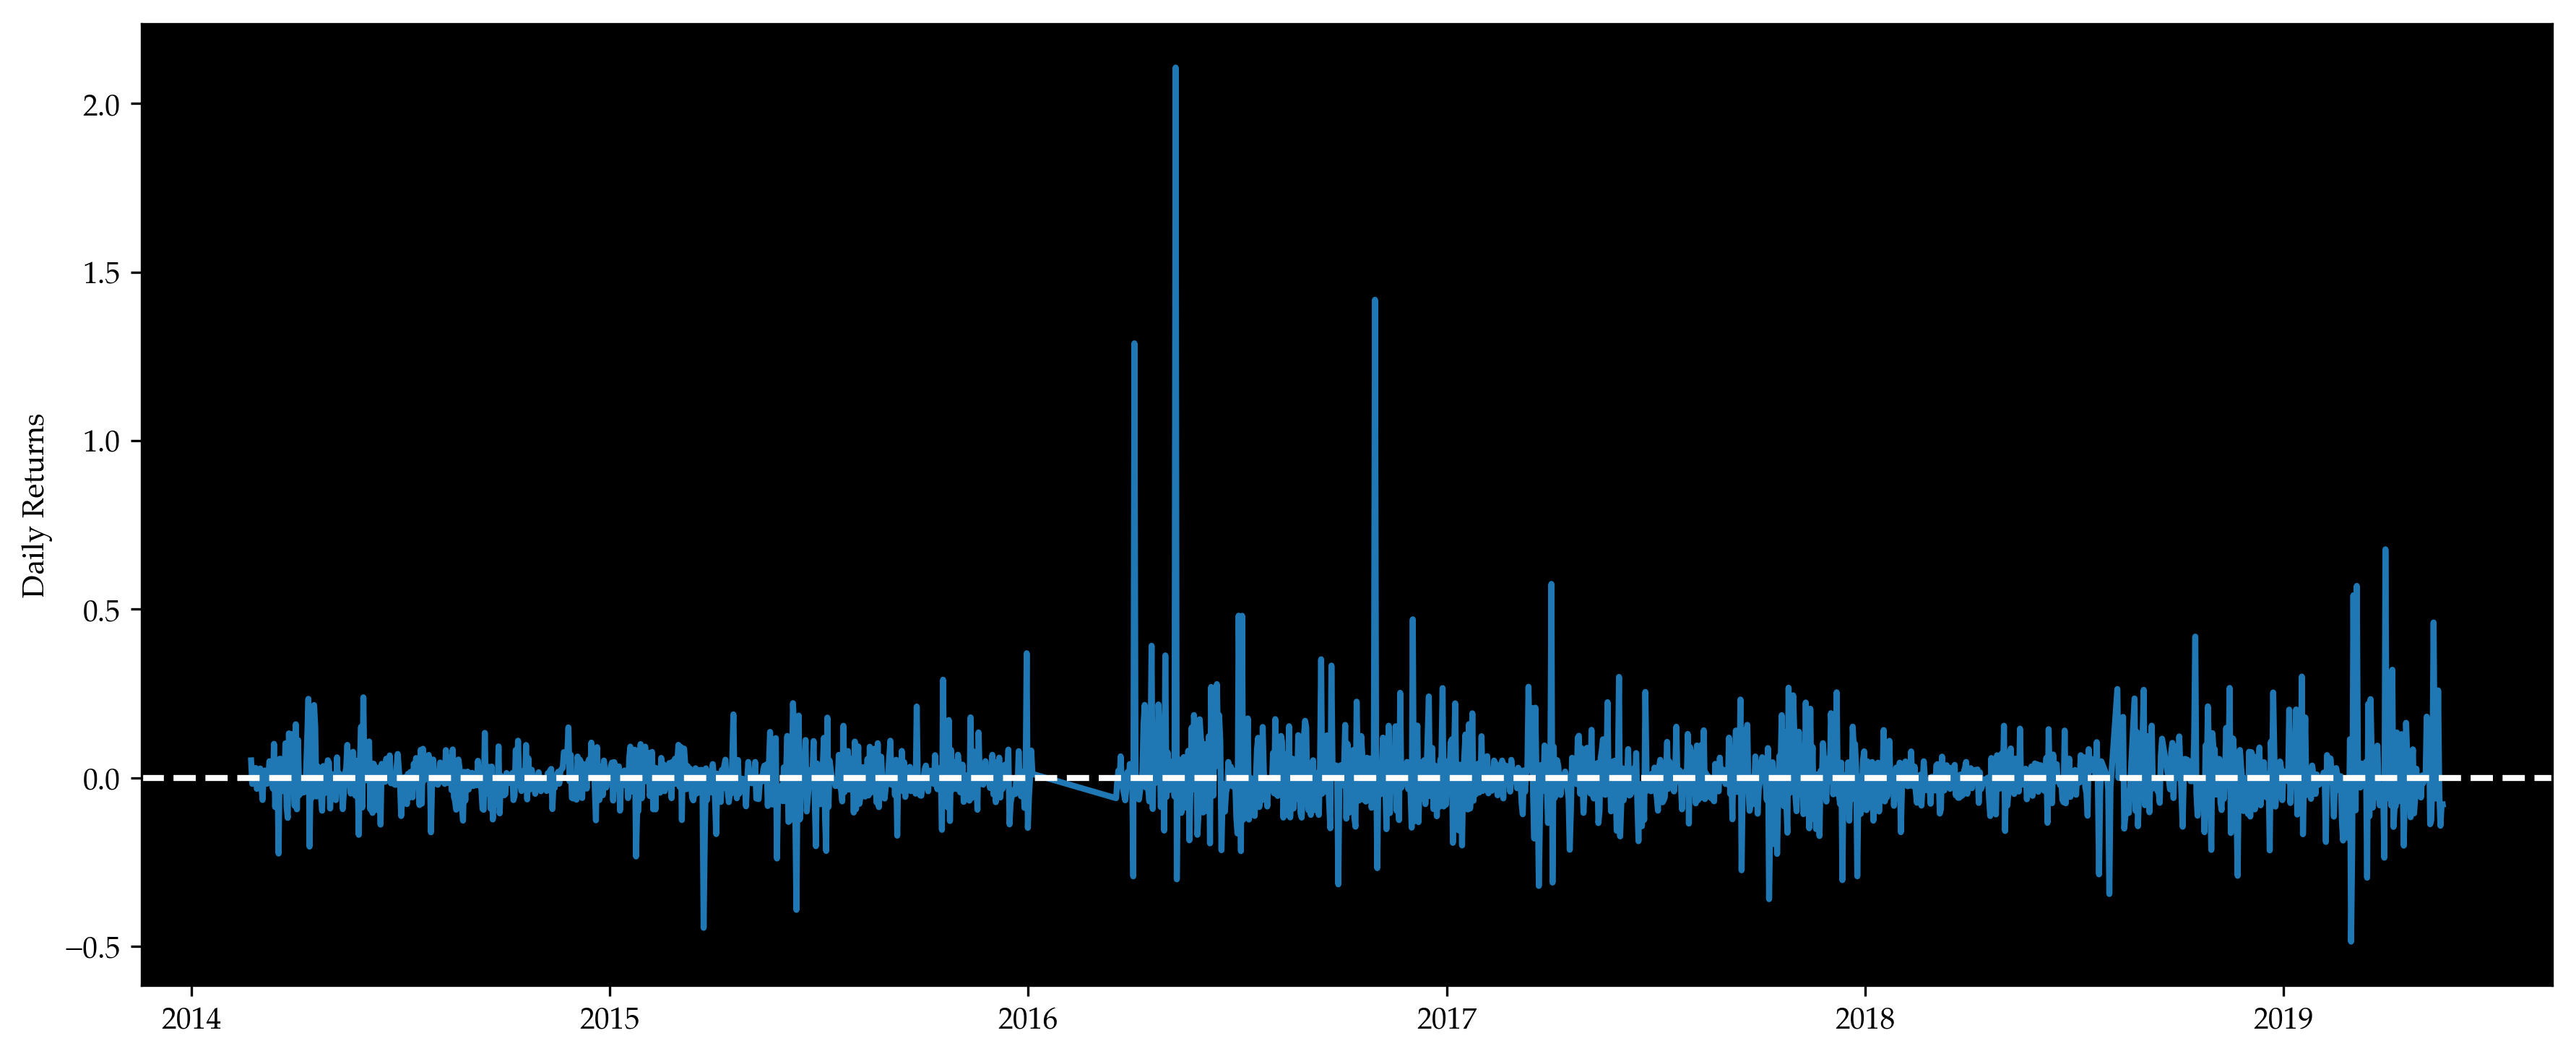

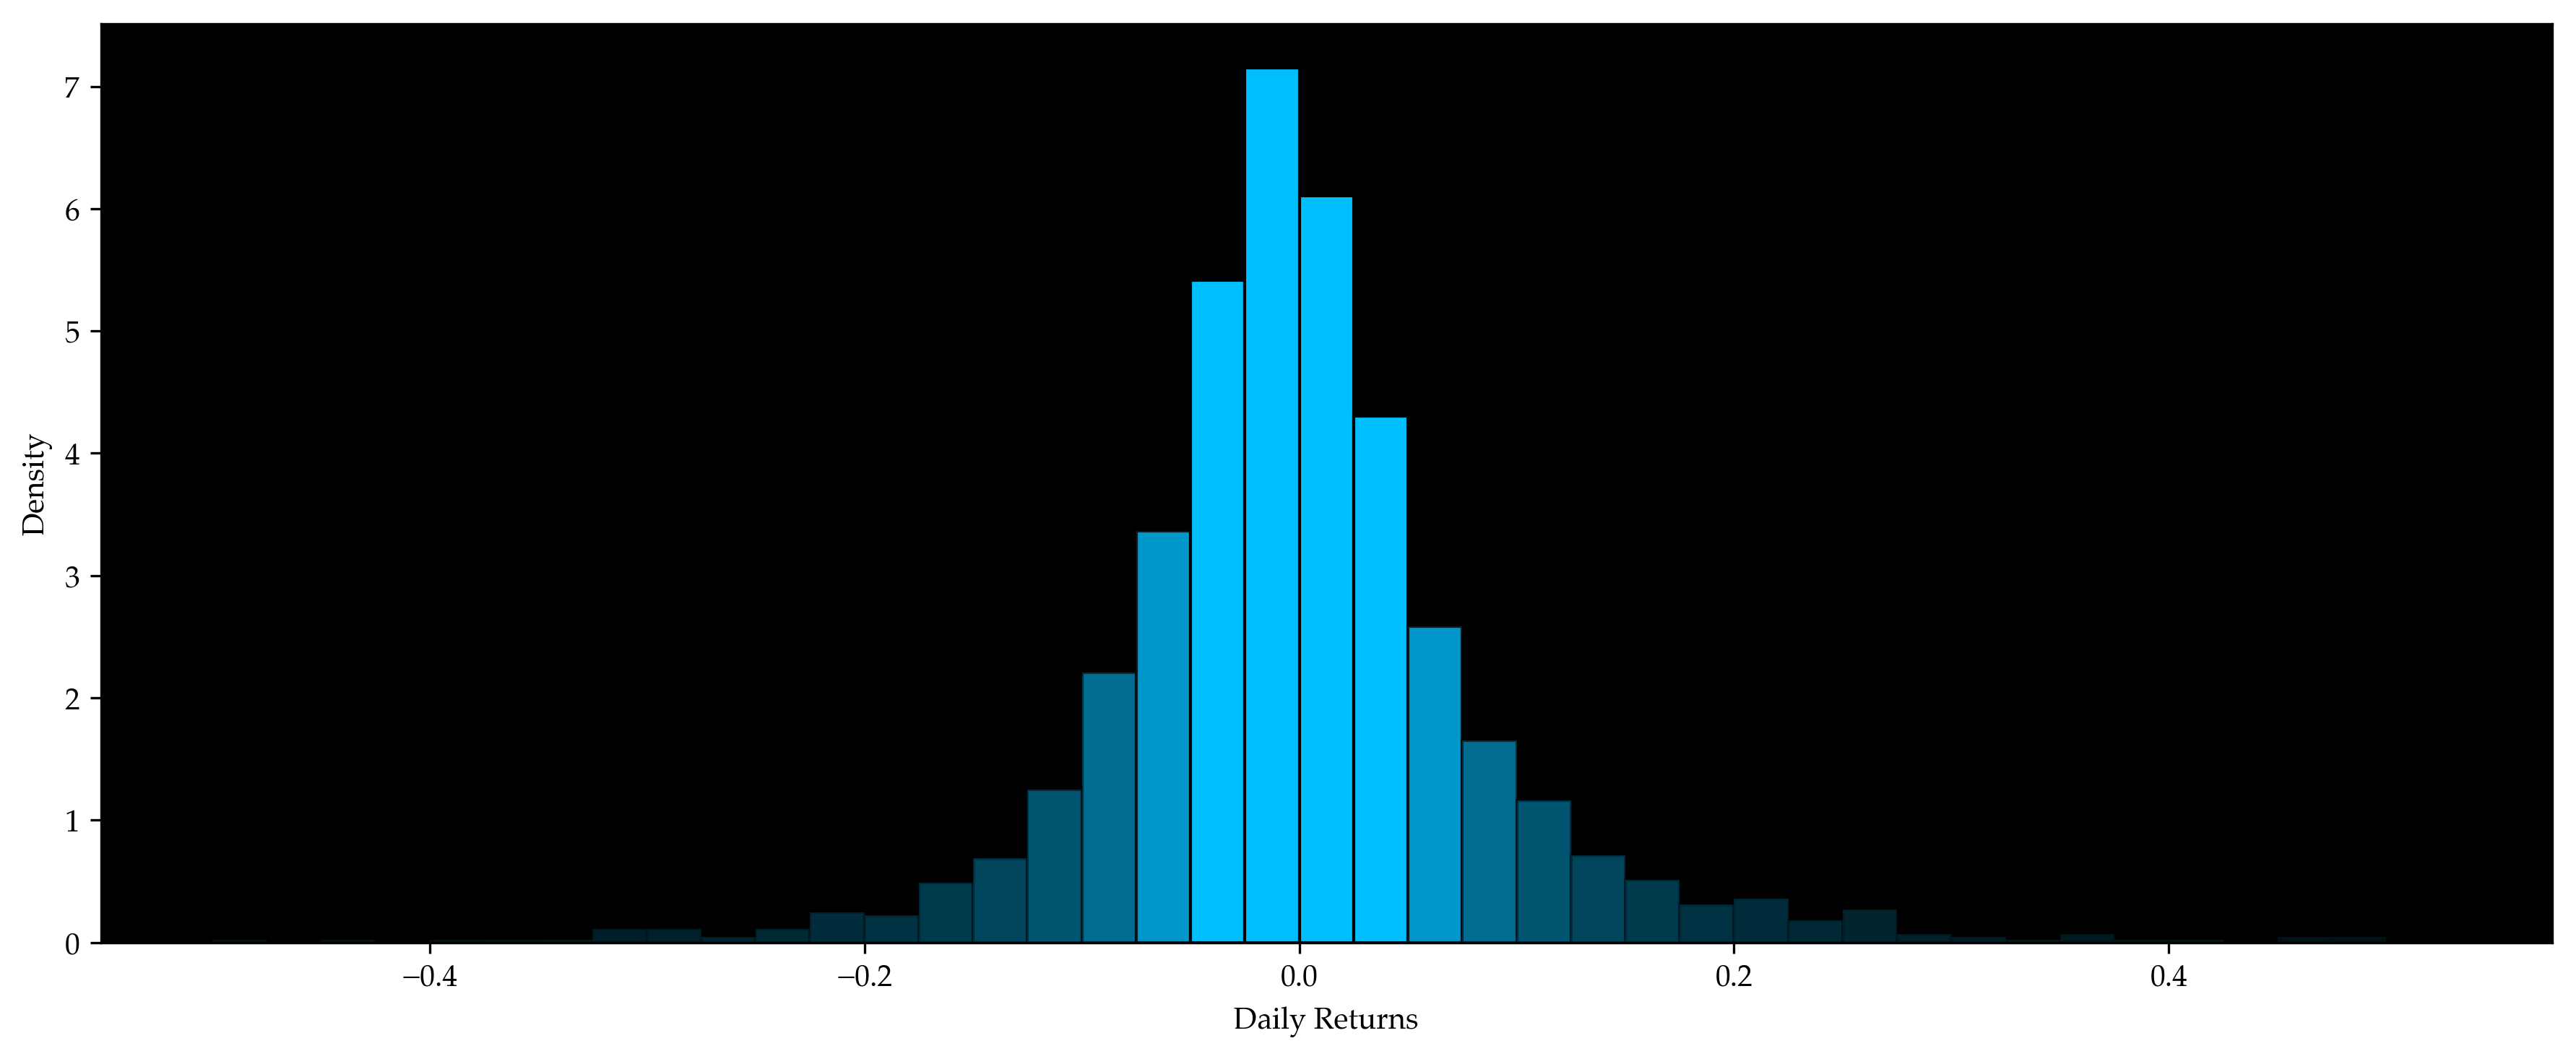

In [18]:
n, d = 3, 60

rtn = price.pct_change().fillna(0)
rtn.index.name = None
temp = (rtn * (mkcap.agg('argsort') < 10)).rolling(d).sum().T
coins = pd.DataFrame(
    [temp.nlargest(n, t).index.tolist() +
     temp.nsmallest(n, t).index.tolist() for t in rtn.index],
    index=rtn.index
).shift().dropna()  # shift to avoid forward-looking bias
display(HTML(coins.to_html(max_rows=10, header=False)))

coef = np.array([1] * n + [-1] * n) / n
rtn = pd.DataFrame([rtn.loc[t, coins.loc[t].values] @ coef for t in coins.index], index=coins.index)[0]
rtn.name = 'r'
print(f'Benchmark strategy has mean return {rtn.mean():.2%} with std {rtn.std():.2f}')

plt.figure()
plt.plot(rtn)
plt.ylabel('Daily Returns')
plt.axhline(y=0, color='w', ls='--')
plt.tight_layout()

plt.figure()
bins = np.arange(-.50, .55, .025)
heights, bins, patches = plt.hist(rtn, bins=bins, edgecolor='k', facecolor='deepskyblue', density=True)
for p in patches:
    x = abs(p.get_bbox().get_points().mean(axis=0)[0]) * 20
    p.set_alpha(1 if x < 1 else 1 / x)
plt.ylabel('Density')
plt.xlabel('Daily Returns')
plt.tight_layout()
plt.show()

df_total = df_eod[['content']].join(rtn, how='inner').dropna()
df_total['p'] = np.argsort(df_total.iloc[:, 1]) / (df_total.shape[0] - 1)
df_total.columns = ['words', 'r', 'p']

test_split = 0.3
len_total = len(df_total)
len_test = round(len_total * test_split)
len_train = len_total - len_test

df_train = df_total.iloc[:len_train, :]
df_test = df_total.iloc[-len_test:, :]
display(HTML(df_train.to_html(max_rows=10)))

Daily returns are positive for about half of the time and negative for the rest of the time. They follow a normal distribution with mean near 0.

Relative Strength Index (RSI) is a momentum indicator that measures the magnitude of recent price changes. Typically, RSIs above 70 or below 30 are considered overbought or oversold. 
The plot below shows RSIs of the coins, the values lie in between 30 and 70 most of the time. From our understanding, it does not imply strong momentum, which also agrees with the return results above.
Because of the dissatisfying return results, we are motivated to make use of news data to help us determine our positions in the portfolio formed by the momentum strategy.

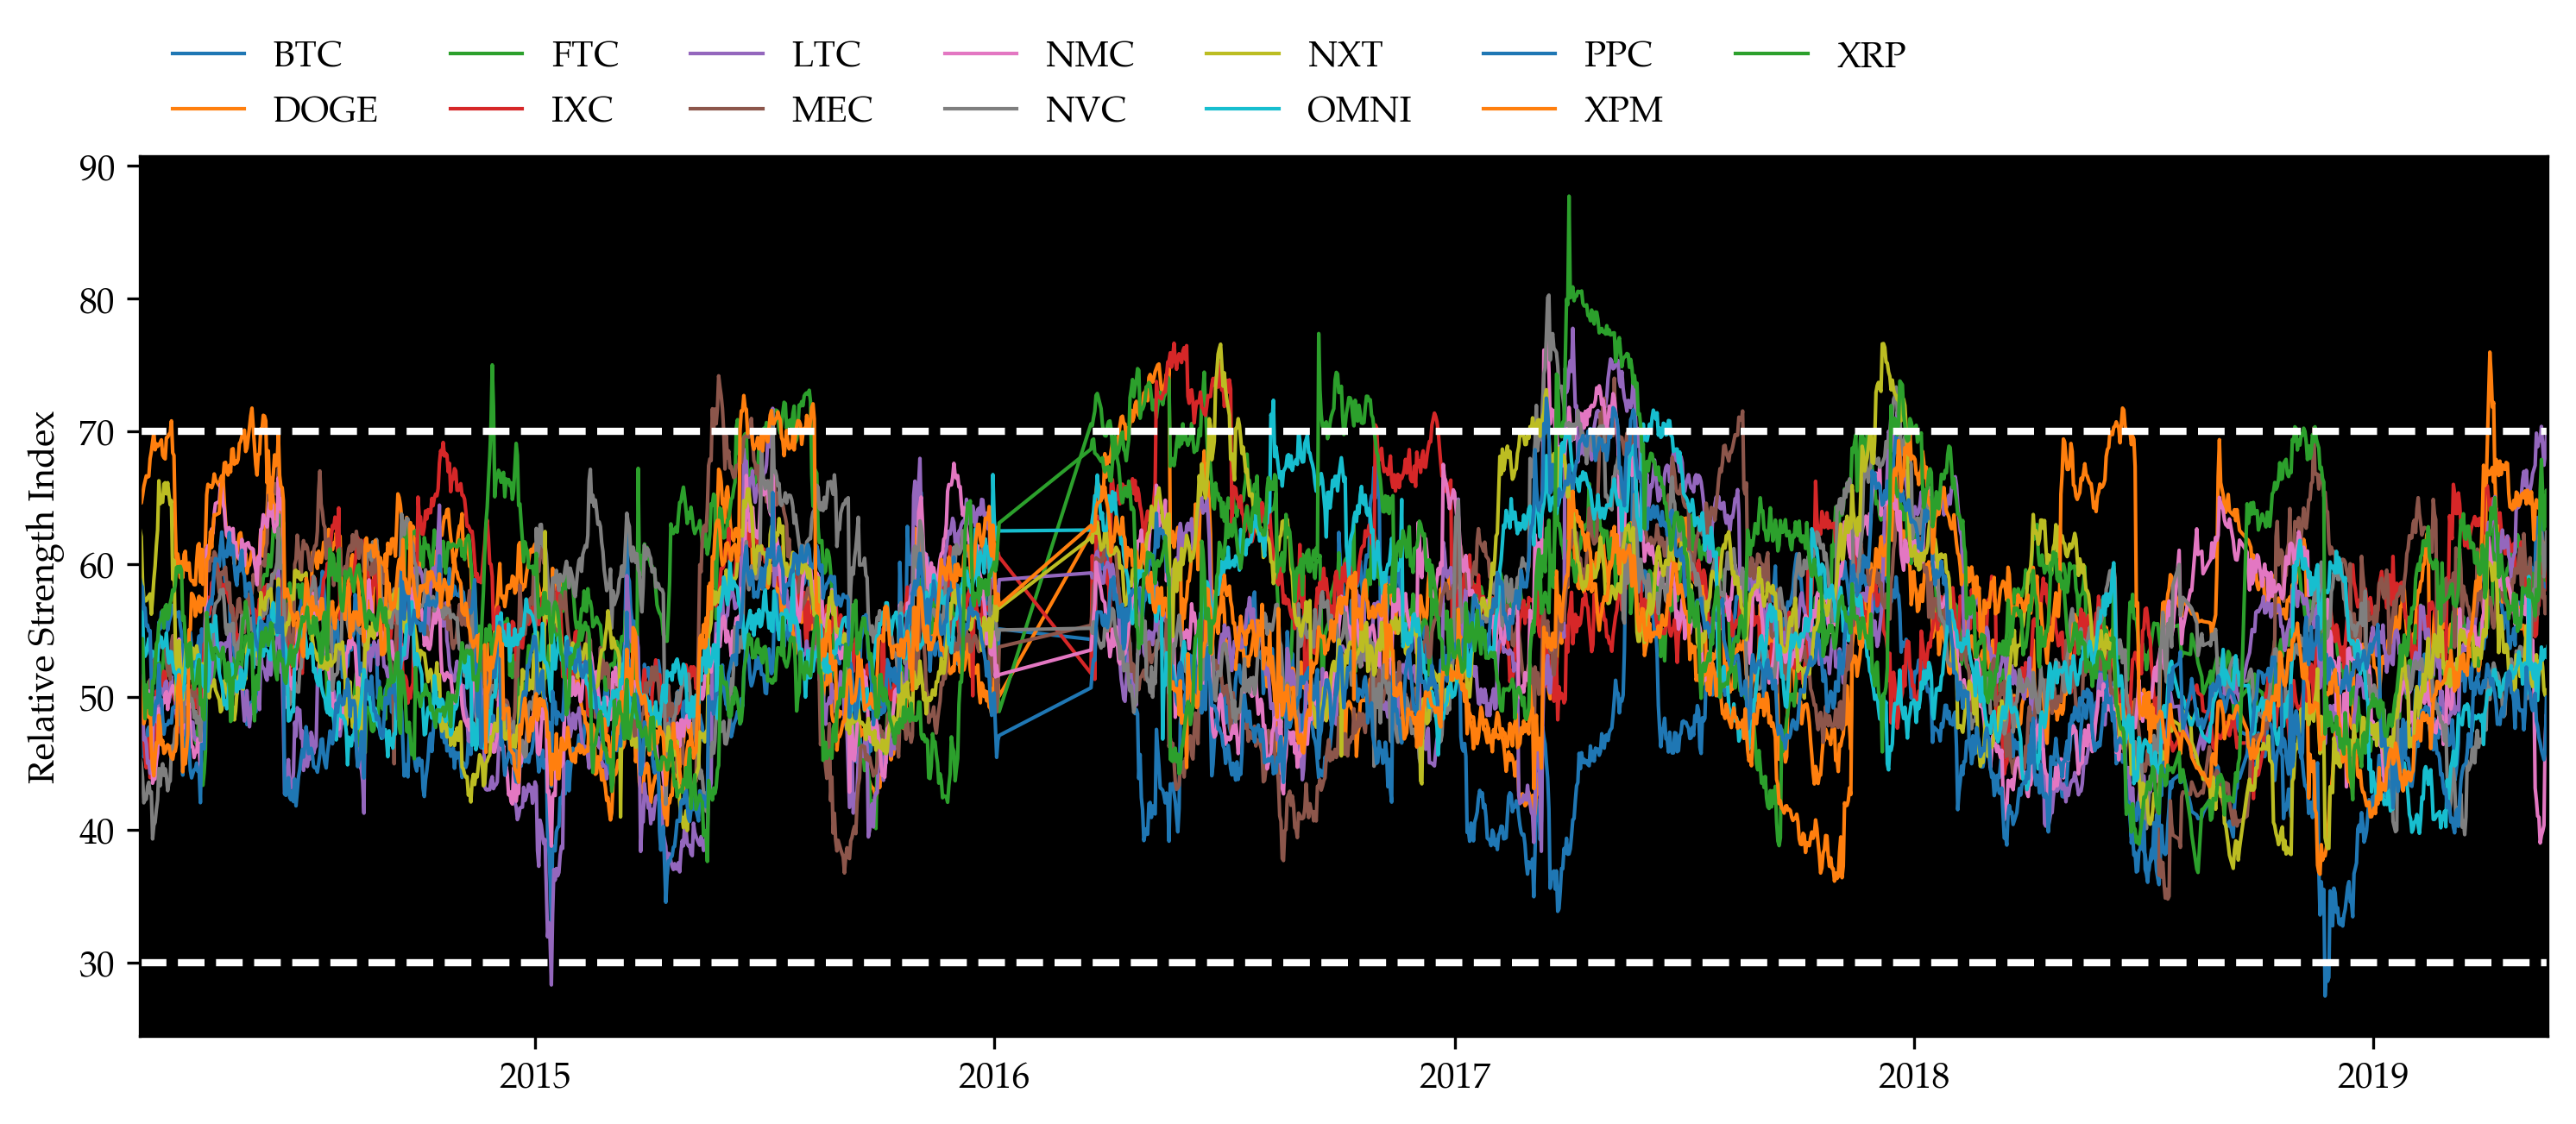

In [19]:
upcloses = lambda x: x[x > 0].mean()
downcloses = lambda x: -x[x < 0].mean()
rsi = 100 - 100 / (1 + price.pct_change().fillna(0).rolling(60).apply(upcloses) / \
                   price.pct_change().fillna(0).rolling(60).apply(downcloses))
display(HTML(rsi.dropna().to_html(max_rows=10, header=True)))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylabel('Relative Strength Index')
for c in rsi.columns:
    rsi[c].dropna().plot(ax=ax, label=c, linewidth=1)
legend = plt.legend(frameon=False, ncol=7, loc='center left', bbox_to_anchor=(0, 1.08))
ax.axhline(y=70, ls='--', color='w')
ax.axhline(y=30, ls='--', color='w')

plt.setp(legend.get_texts(), color='k', size=10)
plt.xticks(rotation=0, ha='center')
plt.show()

Now we may finally start to implement the hybrid model. The algorithm is illustrated below. Instead of `title` or `abstract`, here we test on `content` directly. Contents contain more information than titles or abstracts only, thus enlarging our sample set.

**Step 0**: Calculate the percentage of positive returns on each word $f_j$. Filter words occurring too infrequently. Keep only the top $\alpha_+$ and bottom $\alpha_-$ as the sentiment-charged words. Assume we have in total $k$ such words.

In [20]:
words_all = sorted(list(set(w for words in df_train.words for w in words)))
n = len(words_all)

words_dict = {w: [] for w in words_all}

for i in range(df_train.shape[0]):
    words, r, _ = df_train.iloc[i]
    for w in words:
        words_dict[w].append(r > 0)

words_df = pd.DataFrame({
    'word': words_all,
    'r': [np.mean(words_dict[w]) for w in words_all],
    'k': [len(words_dict[w]) for w in words_all]
}, index=range(n)).sort_values(by='r')
words_df = words_df[words_df.k >= 50][words_df.word.apply(len) >= 5].reset_index(drop=True)
words_df['p'] = np.argsort(words_df.r) / (len(words_df) - 1)
display(HTML(words_df.set_index('word').T.to_html(max_cols=10)))

**Step 1 (Training):** For each date $\newcommand{\bs}{\mathbf}\bs{d}_i = (d_{i,1}, d_{i,2},\ldots,d_{i,k})'$ where $d_{i,j}$ is the count of sentiment-charged word $w_j$ in this day, assume model

$$
\bs{d}_i \sim \text{Multinomial}\left[k, \textstyle{\sum_{j=1}^{k}} d_{i,j}, p_i \bs{O}^+ + (1 - p_i) \bs{O}^-\right].
$$

Where $\bs{O}^+$ is a "positive sentiment day", and describes expected counts of words in a maximally positive sentiment day (one for which $p_i$ = 1). Likewise, $\bs{O}^-$ is a "negative sentiment day" that describes the distribution of word probabilities in maximally negative days (those for which $p_i$ = 0).

Calculate the rank scores of all days as $p_i$, then  estimate $\bs{O}^+$ and $\bs{O}^-$.

In [21]:
alpha = .1
pos_words = words_df[words_df.p > 1 - alpha].word.values.tolist()
neg_words = words_df[words_df.p < alpha].word.values.tolist()
print(f'There are {len(pos_words)} positive words, {len(neg_words)} negative words')

There are 194 positive words, 194 negative words


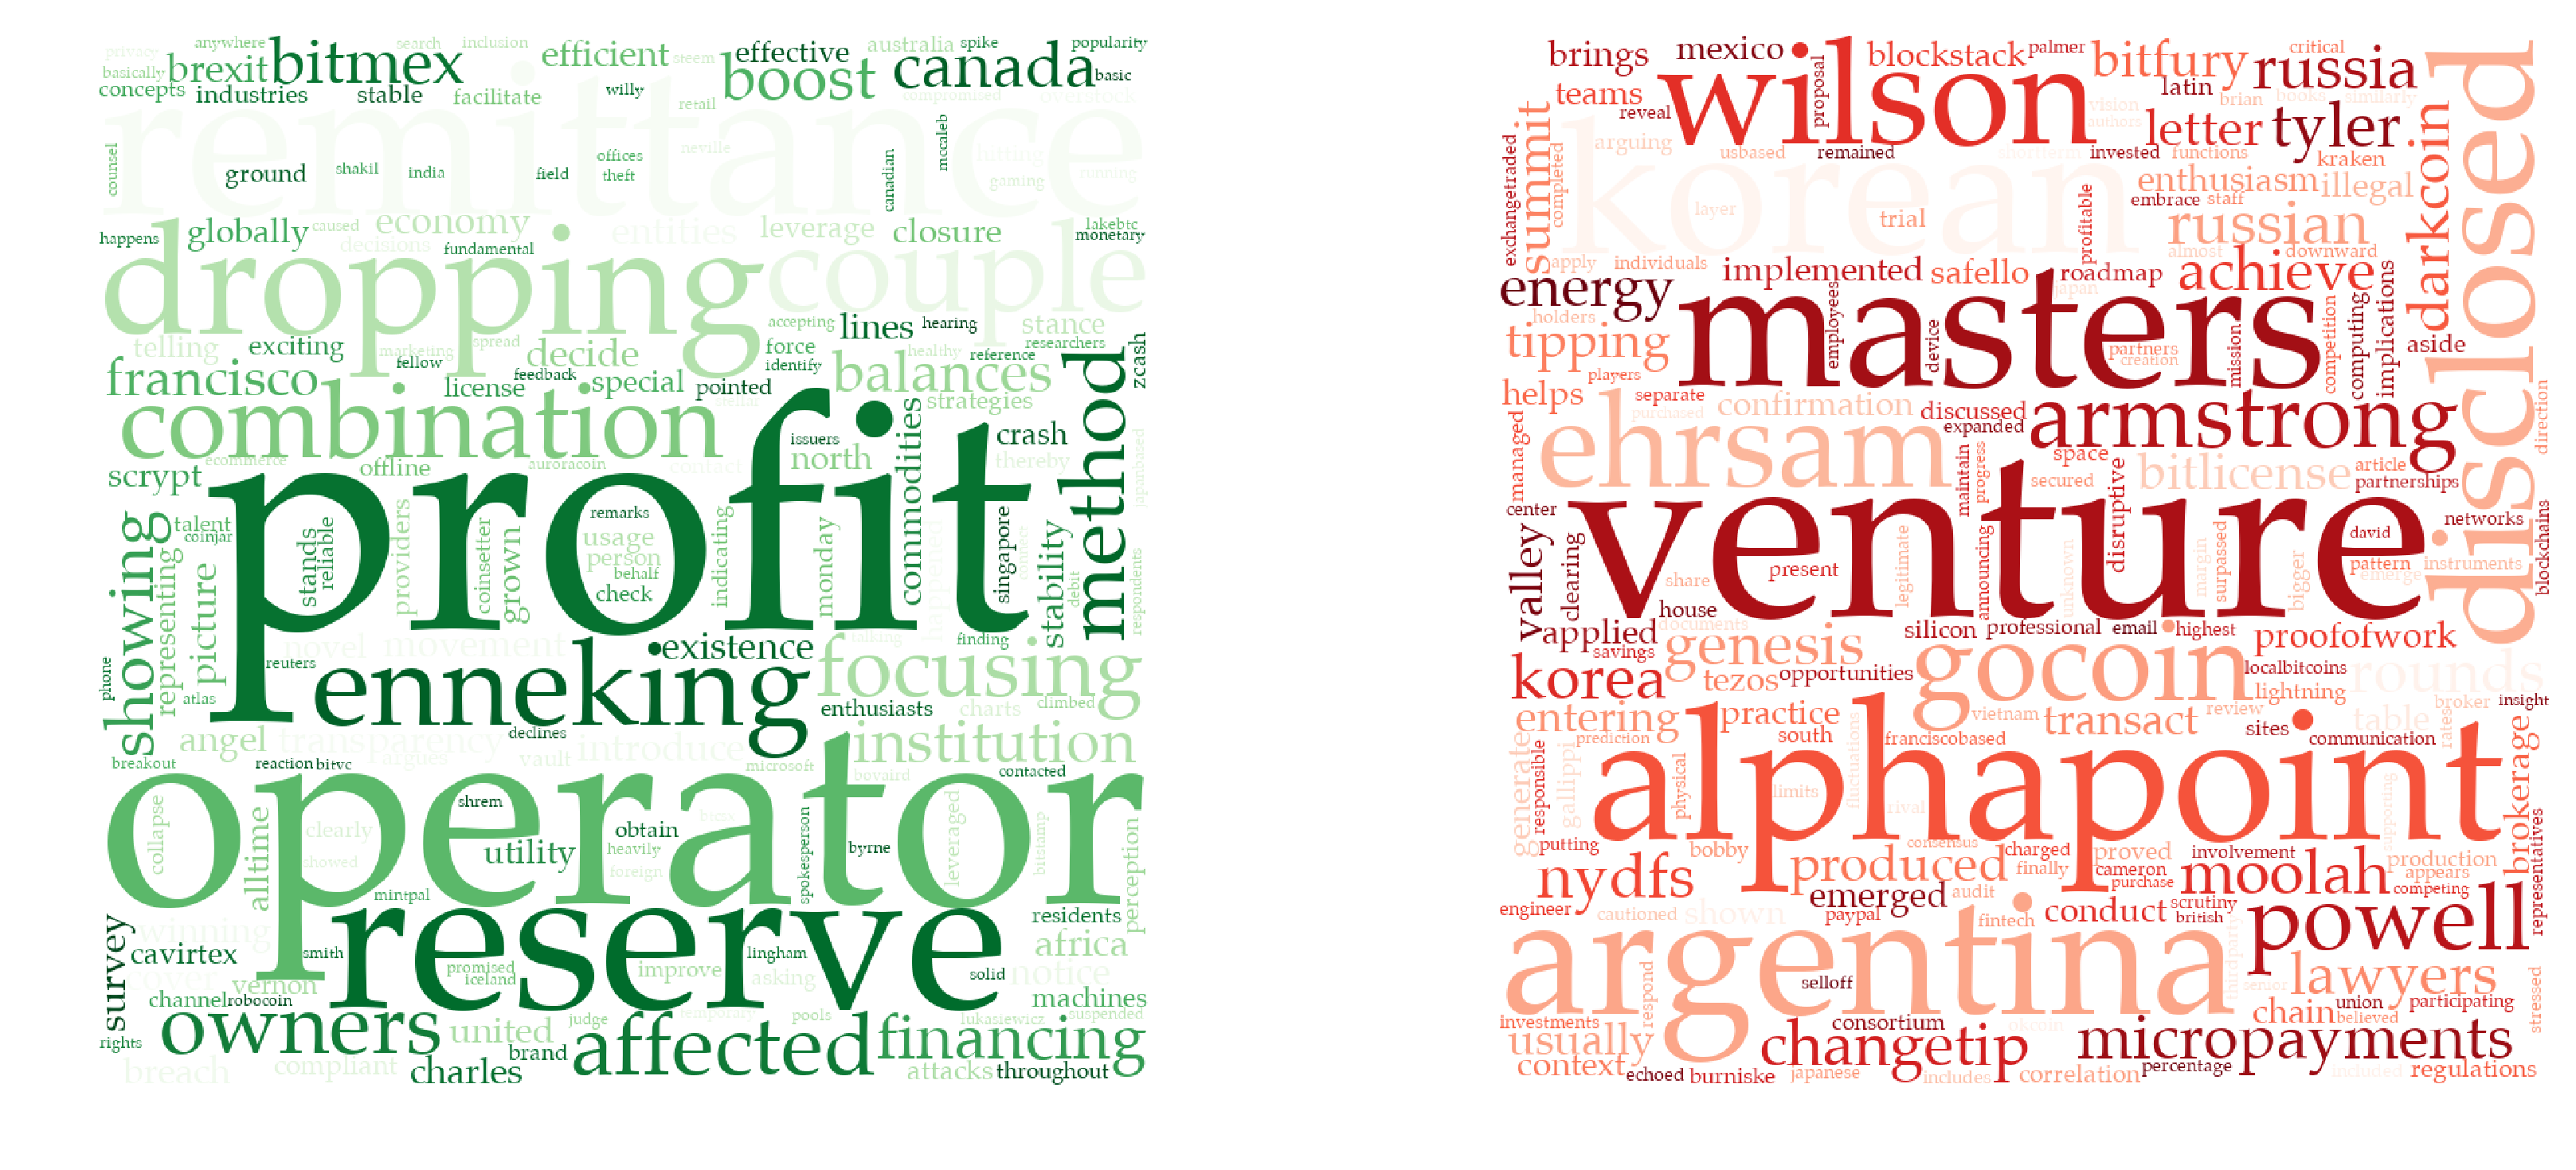

In [22]:
font_path = 'misc/Palatino.ttf'

fig = plt.figure(figsize=(12, 5))

ax = fig.add_subplot(121)
pos_cloud = WordCloud(
    width=800, height=800,
    background_color='white',
    colormap='Greens',
    font_path=font_path,
    min_font_size=10,
    random_state=123
).generate(' '.join(pos_words))
plt.imshow(pos_cloud)
plt.axis('off')

ax = fig.add_subplot(122)
neg_cloud = WordCloud(
    width=800, height=800,
    background_color='white',
    colormap='Reds',
    font_path=font_path,
    min_font_size=10,
    random_state=123
).generate(' '.join(neg_words))
plt.imshow(neg_cloud) 
plt.axis('off')

plt.tight_layout()
plt.show() 

The generated positive and negative word sets are shown above. The bigger the word appears, the more positive or negative it is. Let's look at some examples:

The left green diagram gives all the positive words with $p_i > 1 - \alpha$. The biggest word in the middle is "profit". Most articles containing it express an optimistic view. Examples include "generate a $150,000 profit in bitcoins", and "taking profit from legitimate miners". Other positives words include "boost", "financing", and etc. "Venture", which usually indicates risk, occupies the most space of the right red diagram.

We cannot deny the fact that the relationship between words and returns may be specious. Problems also occur when words such as "not" negate the meaning of sentences. But overall, the classification of words works well with sufficient rationale behind.


We can then estimate $\bs{d}$.

In [23]:
keywords = pos_words + neg_words

def count_words(words):
    c = Counter(words)
    d = [c[w] for w in keywords]
    return np.array(d)

In [24]:
df_train['d'] = df_train.words.apply(count_words).values
display(HTML(df_train.to_html(max_rows=10)))

Now we estimate $\newcommand{\d}{\text{d}}\bs{O}^{+/-}$ using $\bs{d}$ and $p$.

**Estimation by MLE**:

The likelihood is given by

$$
L(\bs{d};\bs{O^{+/-}}) \propto \textstyle{\prod_i\prod_{j=1}^k} [p_i O_j^+ + (1 - p_i) O_j^-]^{d_{i,j}}
$$

and thus the log-likelihood is

$$
LL(\bs{d};\bs{O^{+/-}}) = C + \textstyle{\sum_i \sum_{j=1}^k} d_{i,j} \log[p_i O_j^+ + (1 - p_i) O_j^-]
$$

where $C$ is not a function of $\bs{O}^{+/-}$. Therefore, for each keyword $w_h$,

$$
\frac{\partial LL}{\partial O_h^+} =
\textstyle{\sum_i \sum_{j=1}^k} \frac{d_{i,j}p_i\mathbf{1}\{j=h\}}{p_i O_j^+ + (1 - p_i) O_j^-} =
\textstyle{\sum_i} \frac{d_{i,h}p_i}{p_i O_h^+ + (1 - p_i) O_h^-} > 0
$$

and

$$
\frac{\partial LL}{\partial O_h^-} =
\textstyle{\sum_i \sum_{j=1}^k} \frac{d_{i,j}(1-p_i)\mathbf{1}\{j=h\}}{p_i O_j^+ + (1 - p_i) O_j^-} =
\textstyle{\sum_i} \frac{d_{i,h}(1-p_i)}{p_i O_h^+ + (1 - p_i) O_h^-} > 0.
$$

The optimization problem, therefore, is

\begin{align*}
\max_{\bs{O}^{+/-}}\ & LL(\bs{d};\bs{O}^{+/-})\\
\text{s.t. }         & \textstyle{\sum_{j=1}^k} O_j^+ = \textstyle{\sum_{j=1}^k} O_j^- = 1\\
                     & O_j^+ \ge 0 ,\quad O_j^- \ge 0,\quad \forall 1 \le j \le k.
\end{align*}

Instead of solving this problem using the *Karush-Kuhn-Tucker Conditions*, we may as well do the following transform: let

$$
O_j^{+/-}:=\exp(Q_j^{+/-})
$$

so that the unknowns are now $Q_j^{+/-}\in\mathbb{R}$ and we no longer need any inequality constraints. The Lagrangian is

$$
f(\bs{Q}^{+/-}) = LL\!\left[\bs{d};\exp(\bs{Q}^{+/-})\right] + \lambda^+\!\left[1 - \textstyle{\sum_{j=1}^k} \exp(Q_j^+)\right] + \lambda^-\!\left[1 - \textstyle{\sum_{j=1}^k} \exp(Q_j^-)\right]
$$

and the FOCs are $2k$ equations

$$
0 = \frac{\partial f}{\partial Q_j^{+/-}} =
\frac{\partial LL}{\partial O_j^{+/-}}\frac{\d O_j^{+/-}}{\d Q_j^{+/-}} - \lambda^{+/-} \frac{\d O_j^{+/-}}{\d Q_j^{+/-}}. \quad (1 \le j \le k)
$$

The FOCs can be simplified into

$$
\frac{\partial LL}{\partial O_1^{+/-}} =
\frac{\partial LL}{\partial O_2^{+/-}} =
\cdots =
\frac{\partial LL}{\partial O_k^{+/-}} = \lambda^{+/-}
$$

which is still extremely hard to solve analytically.

**Estimation by Regression**:

This method is proposed in [Ke, Kelly and Xiu (2019)](#kkx2019)<a id='kkx2019back'></a>.

Assume there're in total $\newcommand{\T}{\mathsf{T}}n$ days. Define

$$
\bs{W} = \begin{bmatrix}
p_1 & p_2 & \cdots & p_n\\
1 - p_1 & 1 - p_2 & \cdots & 1 - p_n\\
\end{bmatrix}^\T
$$

and $\bs{D} = \left(\hat{\bs{d}}_1, \hat{\bs{d}}_1, \cdots, \hat{\bs{d}}_n\right)^{\!\T}$ where $\hat{\bs{d}}_i = \bs{d}_i / \textstyle{\sum_j} d_{i,j}$. Then $\bs{O}^{+/-}$ would be estimated by regressing $\bs{D}$ on $\bs{W}$, namely

$$
\hat{\bs{O}}^{+/-} = (\bs{W}^\T \bs{W})^{-1} \bs{W}^\T \bs{D}.
$$

See proof of accuracy in the appendix of the paper.

In [25]:
def print_array(array):
    print(np.array2string(array).replace('[[',' [').replace(']]',']'))

In [26]:
p = df_train.p.values
W = np.vstack([p, 1 - p]).T
print(f'W has shape {W.shape}:')
print_array(W)

W has shape (921, 2):
 [0.96121673 0.03878327]
 [0.23650190 0.76349810]
 [0.65095057 0.34904943]
 ...
 [0.65779468 0.34220532]
 [0.17870722 0.82129278]
 [0.21825095 0.78174905]


In [27]:
D = np.vstack(df_train.d.values)
D = (D.T / D.sum(axis=1)).T
D[np.isnan(D)] = 0
print(f'D has shape {D.shape}:')
print_array(D)

D has shape (921, 388):
 [0.00000000 0.00000000 0.00000000 ... 0.00000000 0.06666667 0.00000000]
 [0.00000000 0.00000000 0.00000000 ... 0.00000000 0.00000000 0.00000000]
 [0.00000000 0.00000000 0.00000000 ... 0.00000000 0.00000000 0.00000000]
 ...
 [0.00000000 0.00000000 0.00000000 ... 0.00000000 0.00000000 0.00000000]
 [0.00000000 0.00000000 0.00000000 ... 0.00000000 0.00000000 0.00000000]
 [0.00000000 0.00000000 0.00000000 ... 0.00000000 0.00000000 0.01219512]


In [28]:
O_pos, O_neg = np.maximum(np.linalg.pinv(W.T @ W) @ (W.T @ D), 0)
O_pos = (O_pos / O_pos.sum())
O_neg = (O_neg / O_neg.sum())
O_pm = np.hstack([O_pos.reshape(-1, 1), O_neg.reshape(-1, 1)])
print(f'O± has shape {O_pm.shape}:')
print_array(O_pm)

O± has shape (388, 2):
 [0.00188745 0.00293239]
 [0.00111679 0.00332143]
 [0.00349693 0.00450815]
 ...
 [0.00396731 0.00174460]
 [0.00407812 0.00318298]
 [0.00753035 0.00733650]


Now that we have already estimated $\bs{O}^{+/-}$, we can start predicting out-of-sample $p$, which indicates the expected rank of performance of a certain day. We're solving $p$ from the following optimization problem

$$
\hat{p} = \arg\!\max_{p\in[0,1]} \left\{\sum_{j=1}^k \hat{d}_j \log\!\left[p O_j^+ + (1 - p) O_j^-\right] + \lambda \log\left[p(1-p)\right]  \right\}
$$

where $\hat{\bs{d}}=\bs{d} / \textstyle{\sum_j}d_j$ like defined above, and $\lambda>0$ is a hyper-parameter for tuning. Let's call it the penalized log-likelihood `pen_ll`.

In [29]:
def pen_ll(p, d, lamda):
    return (d * np.log(p * O_pos + (1 - p) * O_neg)).sum() + lamda * np.log(p * (1 - p))

def predict(d, lamda):
    return minimize(lambda p: -pen_ll(p, d, lamda), x0=.5, method='Nelder-Mead').x[0]

Tune $\lambda$ using training set:

In [30]:
def mse_p(lamda):
    p_hat = np.array([predict(d, lamda) for d in df_train.d])
    return ((df_train.p.values - p_hat)**2).mean()

In [31]:
best_lamda = minimize(mse_p, x0=0, method='Nelder-Mead', bounds=(0, None)).x[0]
best_lamda

3.6398125000000046

**Step 2 (Testing)**: For each date $\bs{d}_i$ observed and $\bs{O}^{+/-}$ fixed, estimate $p_i$ as our final indicator. Specifically, we here use the best $\lambda$ we just estimated above to predict the testing set.

In [32]:
df_test['d'] = df_test.words.apply(count_words).values
df_test['p_hat'] = [predict(d, best_lamda) for d in df_test.d]
df_test = df_test[['words', 'r', 'p', 'p_hat', 'd']]
display(HTML(df_test.to_html(max_rows=10)))

### Backtesting Results  [↩](#modbback)<a id='modb'></a>

Finally, given the predicted `p_hat` values, we can trade based on certain sizing functions and calculate the cumulative return as well as all other trading related statistics of our strategy. We will also calculate these for benchmark strategies.

**A short description of benchmark strategies and our hybrid sentiment-momentum strategy:**

**Buy-and-hold**: This strategy simply buys Bitcoin and hold for the whole trading period. Bitcoin is the most commonly traded coin in the cryptocurrency market and is representative of the market. Thus, we choose Bitcoin as the asset we buy and hold.

**Momentum**: As explained above, the momentum strategy takes long and short positions separately in the top `n` and bottom `n` coins. Here, by "top" and "bottom", we mean the best- and worst-performing coins in the look-back window of `d` trading days. Specifically, we take `n=3` and `d=60`. 

**Momentum Reversal**: The momentum reversal strategy does exactly the opposite of the momentum strategy. It takes short positions in the top `n` coins and long positions in the bottom `n` coins. The definition and values of `n` and `d` remain the same.

**Hybrid Sentiment-momentum**: Our hybrid sentiment-momentum strategy combines sentiment analysis and momentum trading strategy. Using the core idea of momentum, the strategy ranks all the coins based on their previous price changes and then forms a portfolio that enters long positions in coins that headed up and short positions in those that went down. This step is the same as a usual momentum trading strategy. Taking advantage of the sentiment analysis results on present da's news, the strategy then decides on how many units of the portfolio to buy or sell.

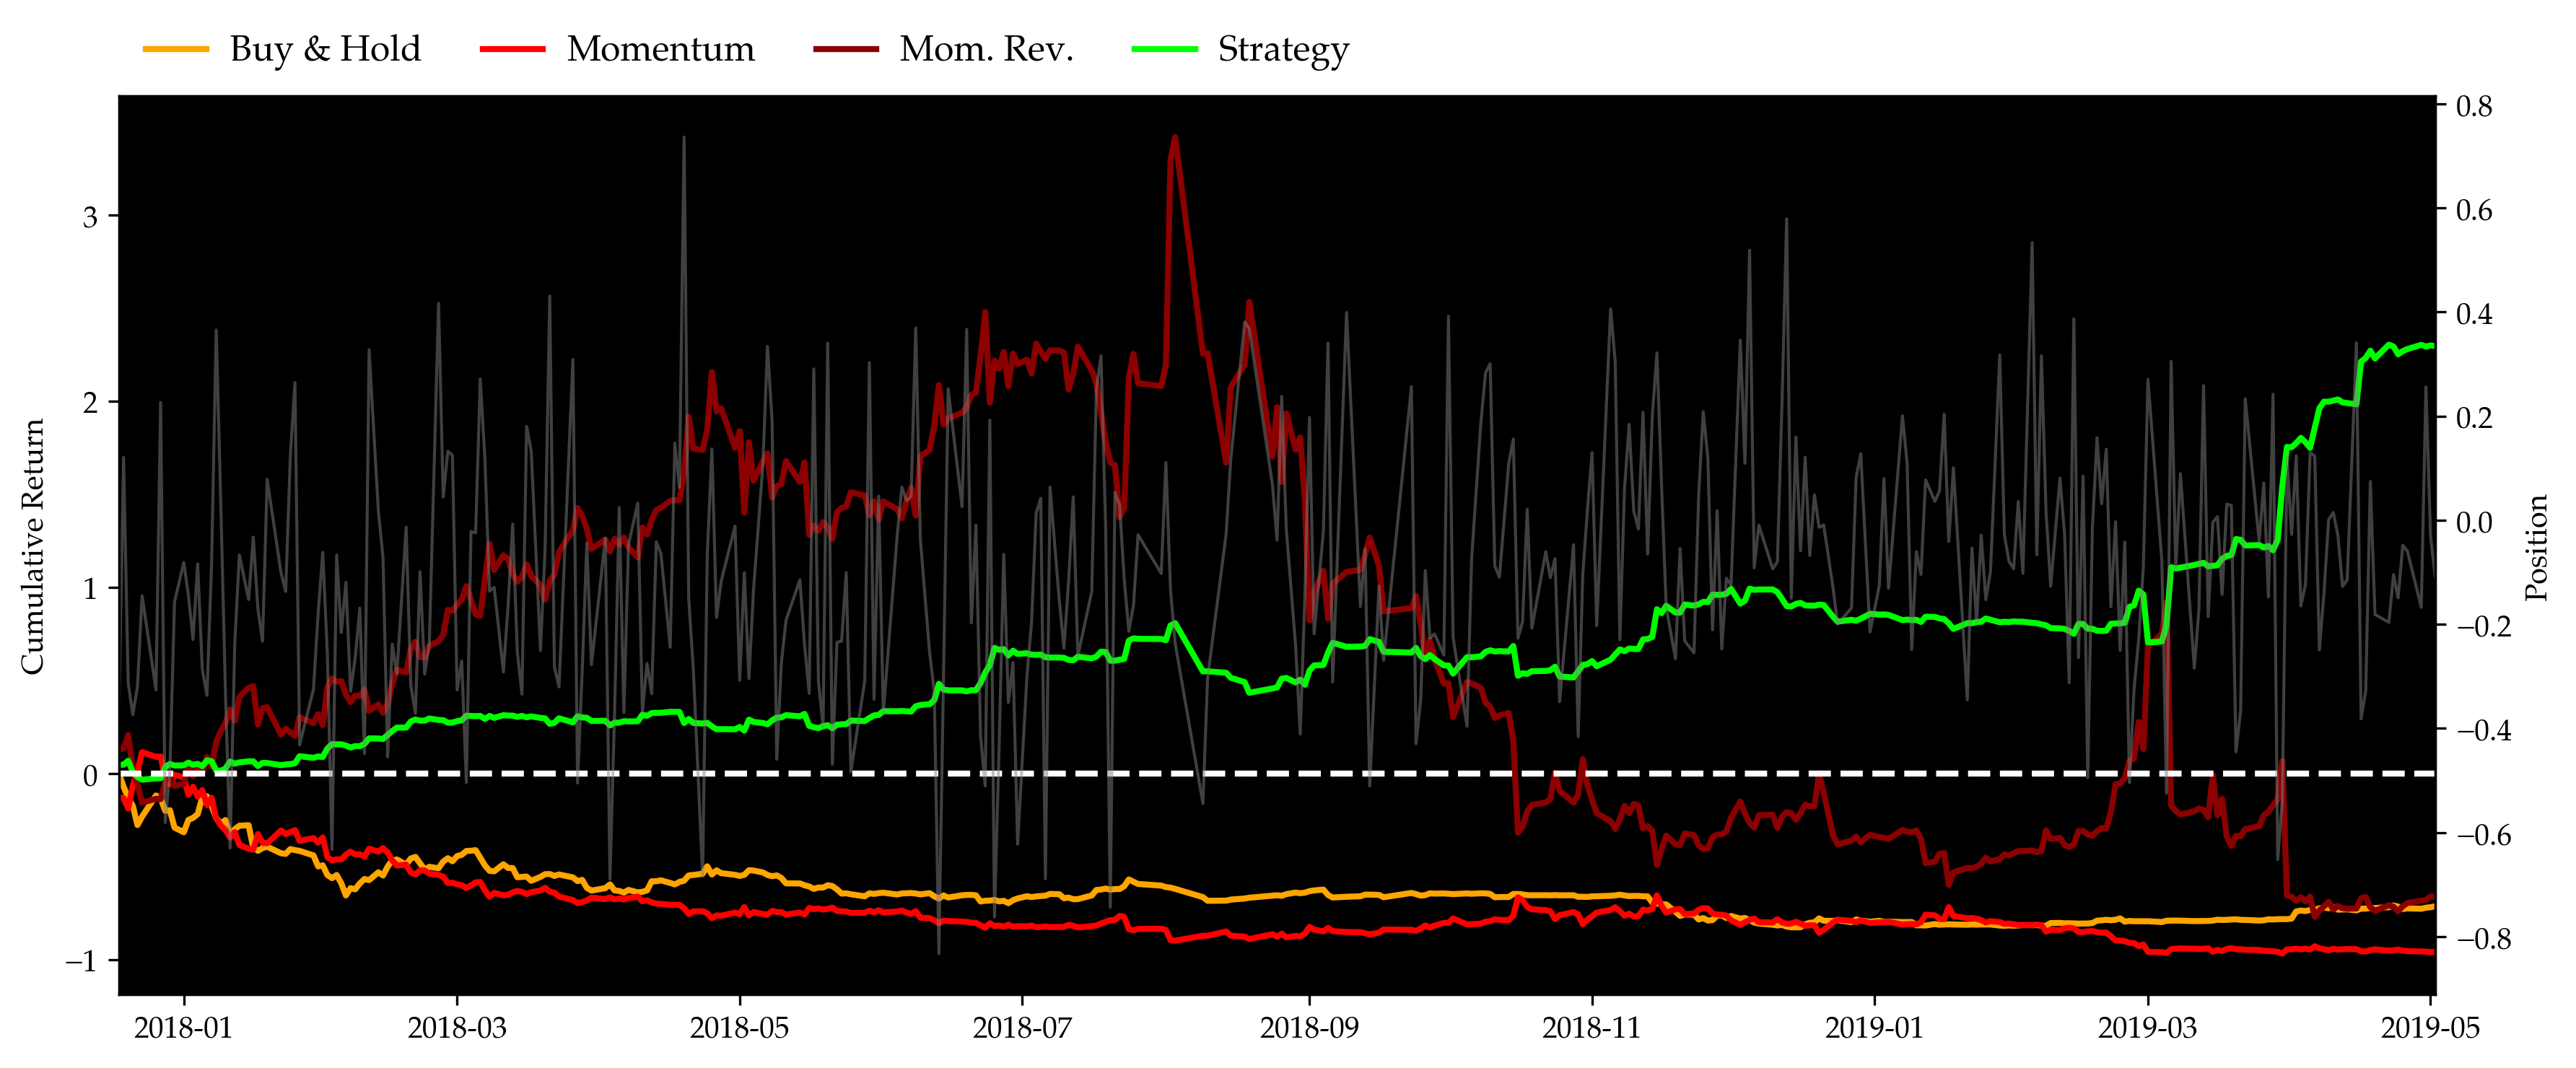

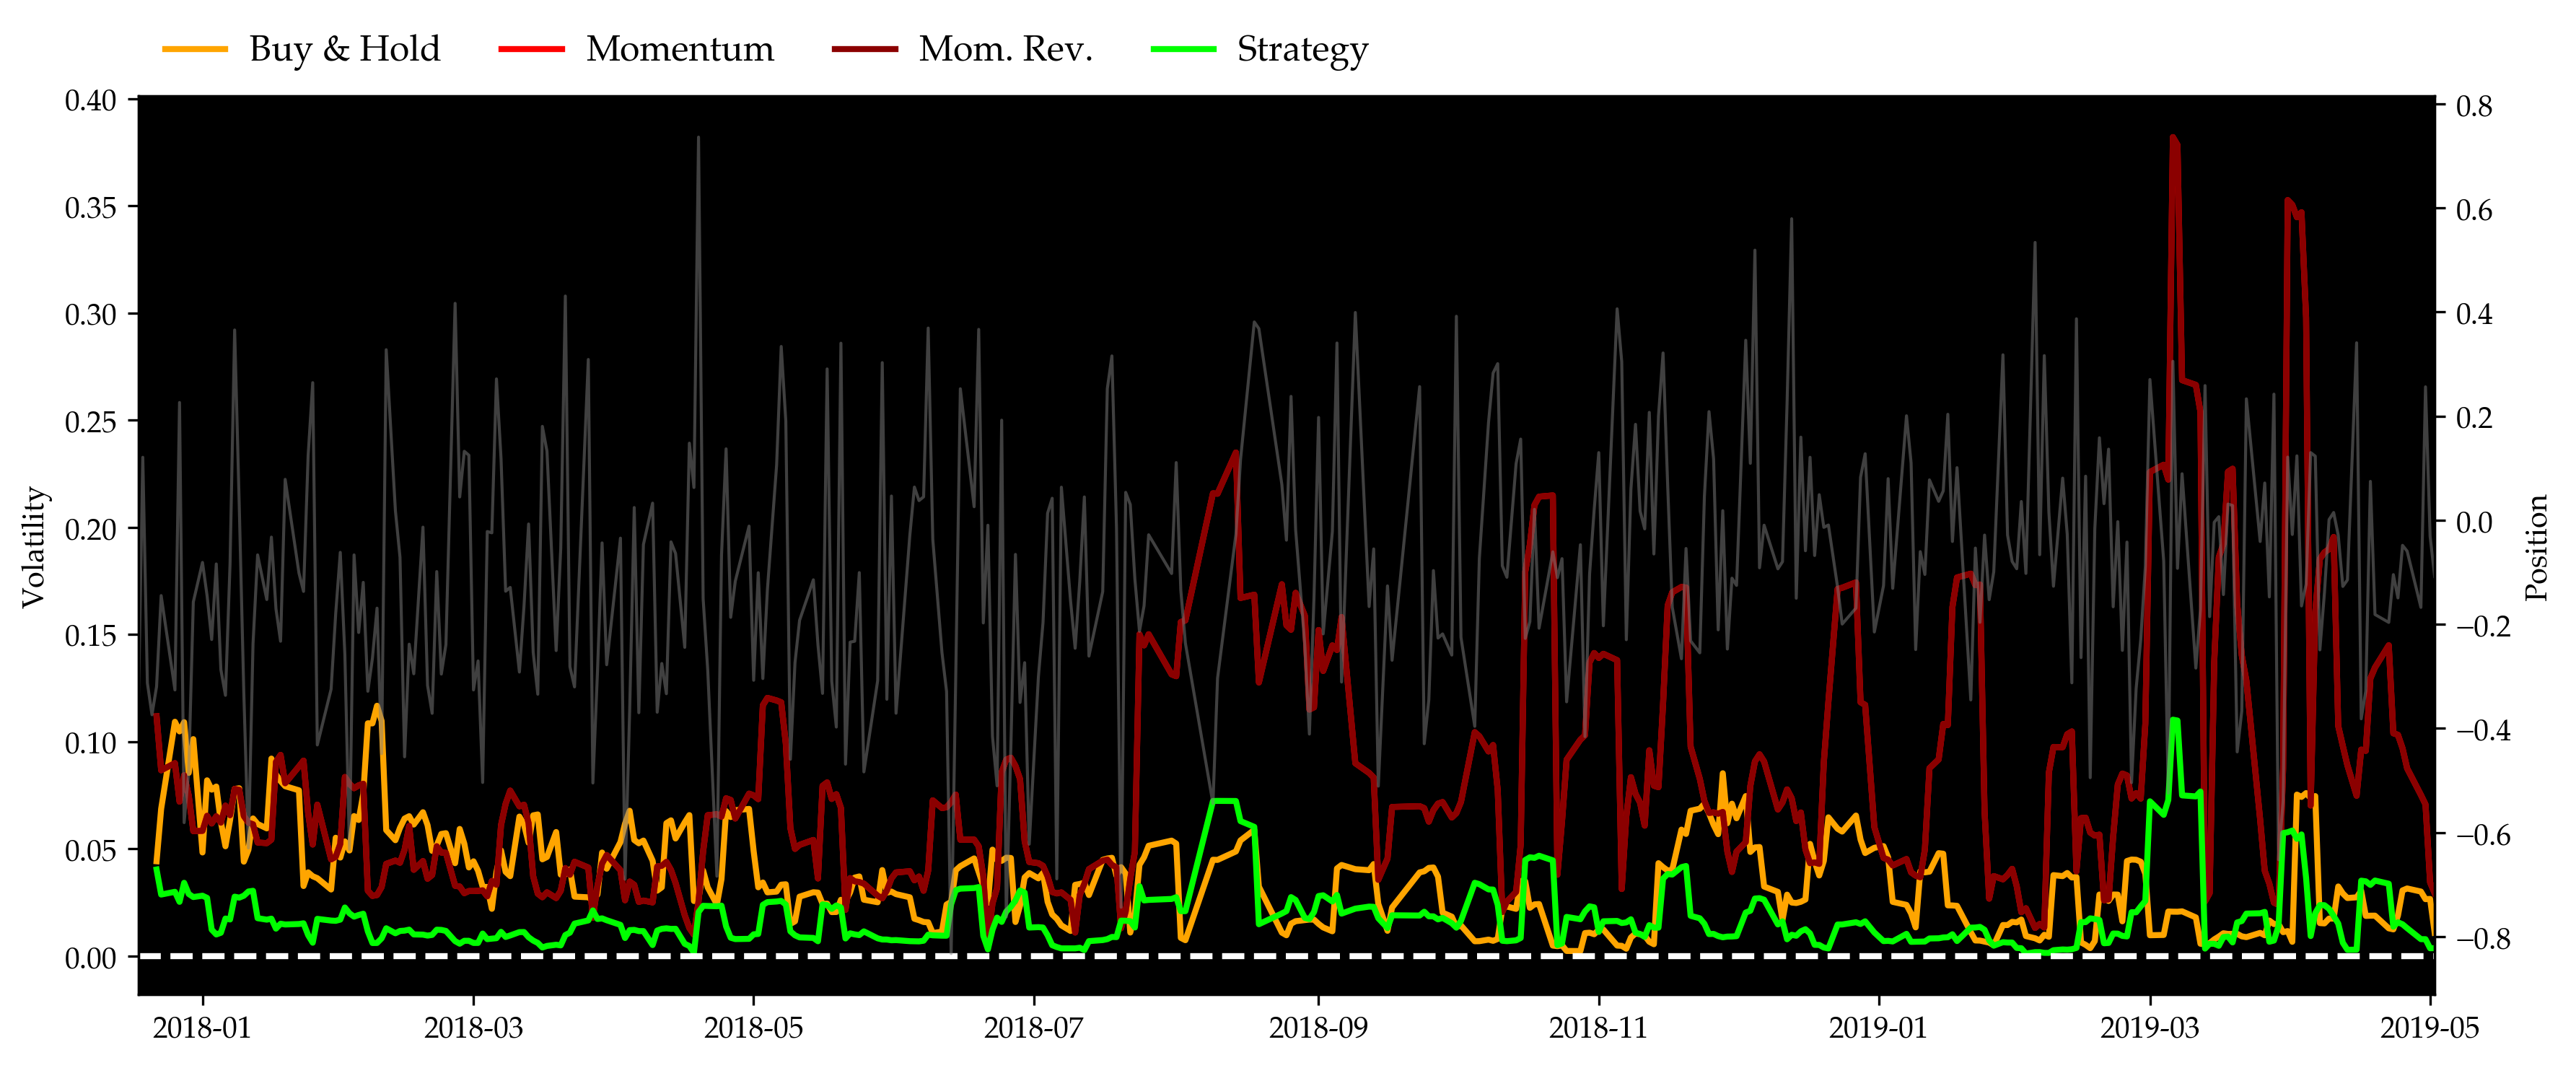

In [33]:
size = lambda x: x * 2 - 1  # actual size of position based on predicted p values
compound = lambda x: (1 + x).cumprod() - 1

r = df_test.r
size = df_test.p_hat.apply(size)

daily_rtn = r * size
cum_rtn = compound(daily_rtn)

daily_rtn_momentum = rtn[cum_rtn.index]
cum_rtn_momentum = compound(daily_rtn_momentum)

daily_rtn_momentum_rev = -daily_rtn_momentum
cum_rtn_momentum_rev = compound(daily_rtn_momentum_rev)

daily_rtn_buy_hold = price.BTC.pct_change().loc[cum_rtn.index]
cum_rtn_buy_hold = compound(daily_rtn_buy_hold)



fig1 = plt.figure()

ax1 = fig1.add_subplot(111)
ax1.set_ylabel('Cumulative Return')
cum_rtn_buy_hold.plot(ax=ax1, color='orange', label='Buy & Hold')
cum_rtn_momentum.plot(ax=ax1, color='r', label='Momentum')
cum_rtn_momentum_rev.plot(ax=ax1, color='darkred', label='Mom. Rev.')
cum_rtn.plot(ax=ax1, color='lime', label='Strategy')
ax1.axhline(y=0, ls='--', color='w')
legend1 = plt.legend(frameon=False, ncol=10, loc='center left', bbox_to_anchor=(0, 1.05))
plt.setp(legend1.get_texts(), color='k', size=12)
plt.xticks(rotation=0, ha='center')

ax1 = ax1.twinx()
ax1.grid(False)
ax1.set_ylabel('Position')
size.plot(ax=ax1, lw=1, alpha=.5, color='grey')
plt.tight_layout()

fig2 = plt.figure()

ax2 = fig2.add_subplot(111)
ax2.set_ylabel('Volatility')
daily_rtn_buy_hold.rolling(5).std().plot(ax=ax2, color='orange', label='Buy & Hold')
daily_rtn_momentum.rolling(5).std().plot(ax=ax2, color='r', label='Momentum')
daily_rtn_momentum_rev.rolling(5).std().plot(ax=ax2, color='darkred', label='Mom. Rev.')
daily_rtn.rolling(5).std().plot(ax=ax2, color='lime', label='Strategy')
ax2.axhline(y=0, ls='--', color='w')
legend2 = plt.legend(frameon=False, ncol=10, loc='center left', bbox_to_anchor=(0, 1.05))
plt.setp(legend2.get_texts(), color='k', size=12)
plt.xticks(rotation=0, ha='center')

ax2 = ax2.twinx()
ax2.grid(False)
ax2.set_ylabel('Position')
size.plot(ax=ax2, lw=1, alpha=.5, color='grey')

plt.tight_layout()
plt.show()



win_rate = lambda x: (x > 0).mean()
sharpe = lambda x: x.mean() / x.std() * np.sqrt(360)
mdd = lambda x: (1 - x / x.cummax()).max()

DAILY = [daily_rtn_buy_hold, daily_rtn_momentum, daily_rtn_momentum_rev, daily_rtn]
CUM = [cum_rtn_buy_hold, cum_rtn_momentum, cum_rtn_momentum_rev, cum_rtn]

cr = [x[-1] for x in CUM]
vol = [x.std() for x in DAILY]
wr = [win_rate(x) for x in DAILY]
sr = [sharpe(x) for x in DAILY]
md = [mdd(x + 1) for x in CUM]
result = pd.DataFrame({
    'Cum Return': cr,
    'Volatility': vol,
    'Win%': wr,
    'Sharpe': sr,
    'MDD': md
}, index=['Buy & Hold', 'Momentum', 'Mom. Rev.', 'Strategy'])
result.index.name = 'Statistics'
display(HTML(result.T.to_html(max_rows=10)))

As can be seen in the figure above, the momentum strategy performed almost as poorly as a simple buy & hold throughout the bearish year of 2018. The momentum reversal strategy, on the other hand, performed extremely well at the first half year and then collapsed with the market. The partially reflects the existence of price overreactions as suggested by [Caporale and Plastun (2018)](#cp2018)<a id='cp2018back'></a>. Our hybrid strategy, on the other hand, outperformed all of them by over 100% cumulative returns by the end of backtest, and gave a Sharpe ratio of 2.68 when best of the rest, which is given by momentum reversal, is merely 0.60 or so. Volatility plot also shows that by adding sentiment analysis to determine position sides and sizes of the portfolio, the hybrid strategy significantly reduces the risks that existed in the momentum strategy. Also, considering the maximum drawdowns, all of the three benchmarks gave gigantic drawdowns in this unfortunate year, while our strategy's was well limited under 20% most of the time. 

### Model Sensitivity to Parameters  [↩](#sensback)<a id='sens'></a>

The following parameters are included in our model. We want to test how the model reacts towards changes in them.
- `lookback_window` is the number of days we feed our model for training,
- `minimum_occurrence` is the minimum acceptable number of occurrences for a word to be qualified as sentiment-charged,
- `minimum_length` is the minimum acceptable length of a word to be considered sentiment-charged,
- `alpha` is the top (and bottom) percentile for sentiment-charged word selection
- `size` is a univariate function mapping $[0,1]\subset\mathbb{R}$ to $[-1,1]\subset\mathbb{R}$.

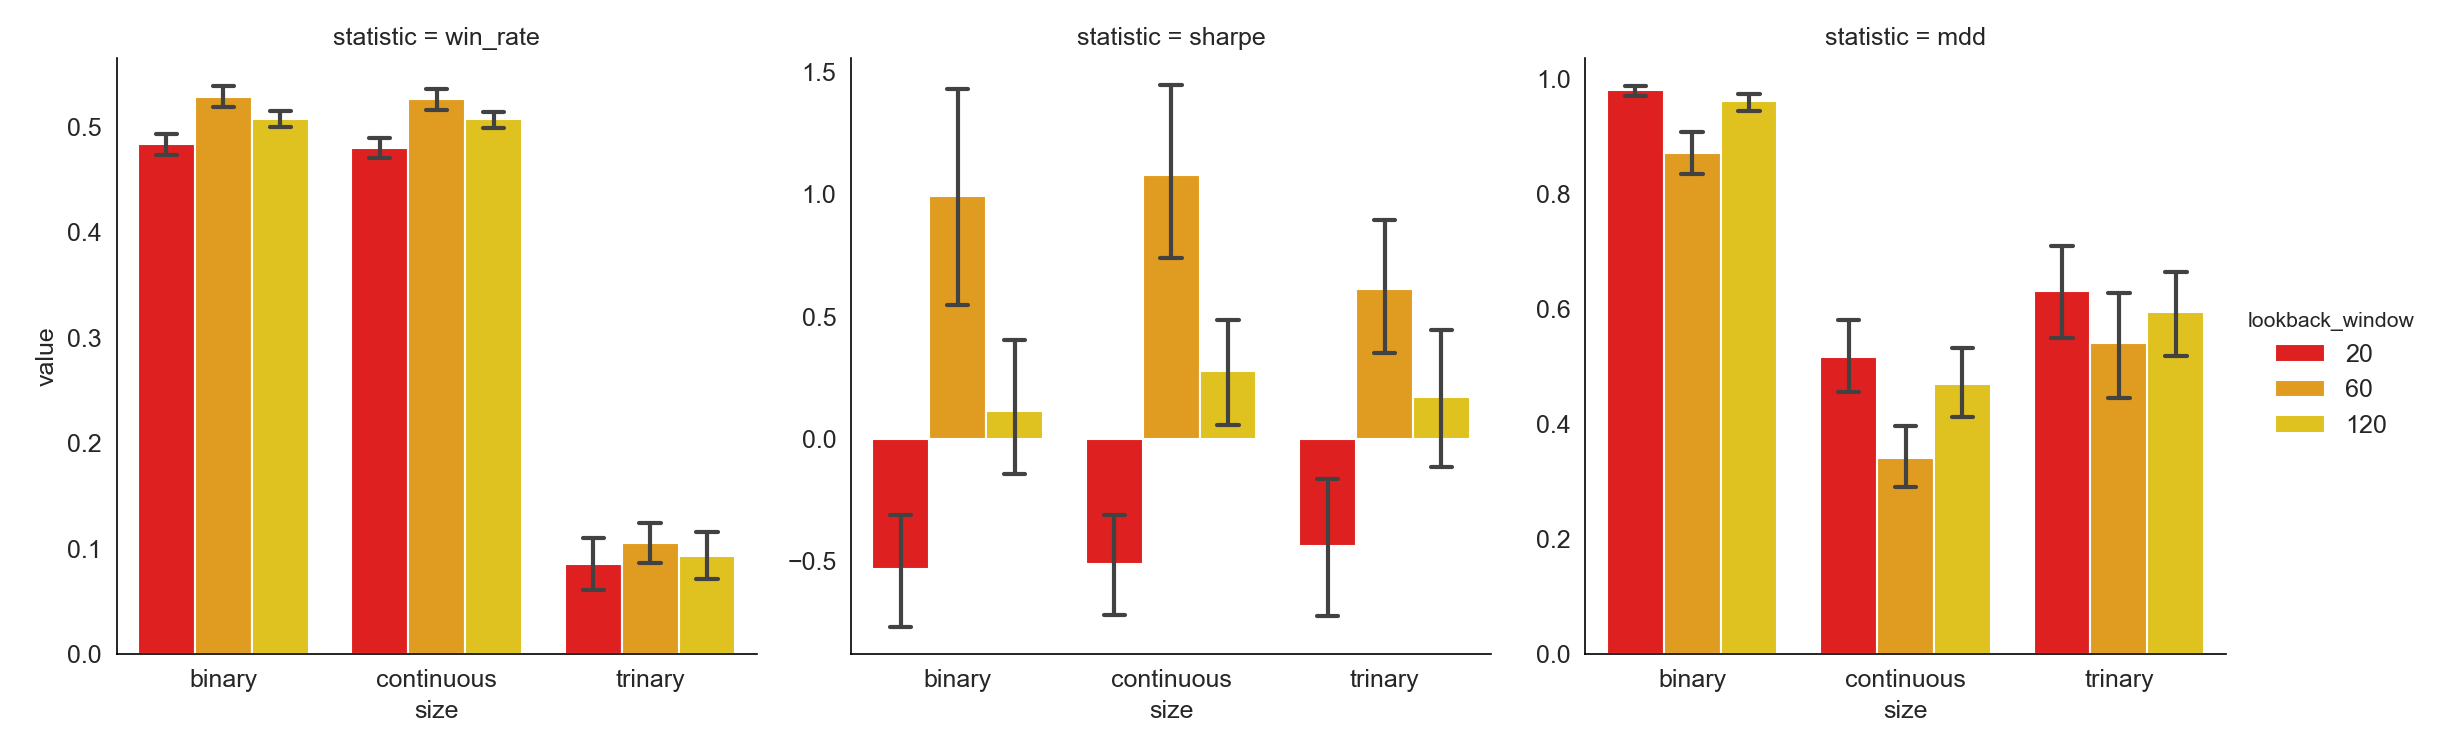

In [34]:
Image('misc/lookback_window.png')

A longer look-back window provides more information in the past that can be used to help decision-making on forming the portfolio. However, the longer the window, the more stale information is included. The empirical result tells us using past 60 day' information to determine the best and worst performing coins eventually leads to the highest Win rate and Sharpe Ratio together with the lowest Maximum Drawdown.

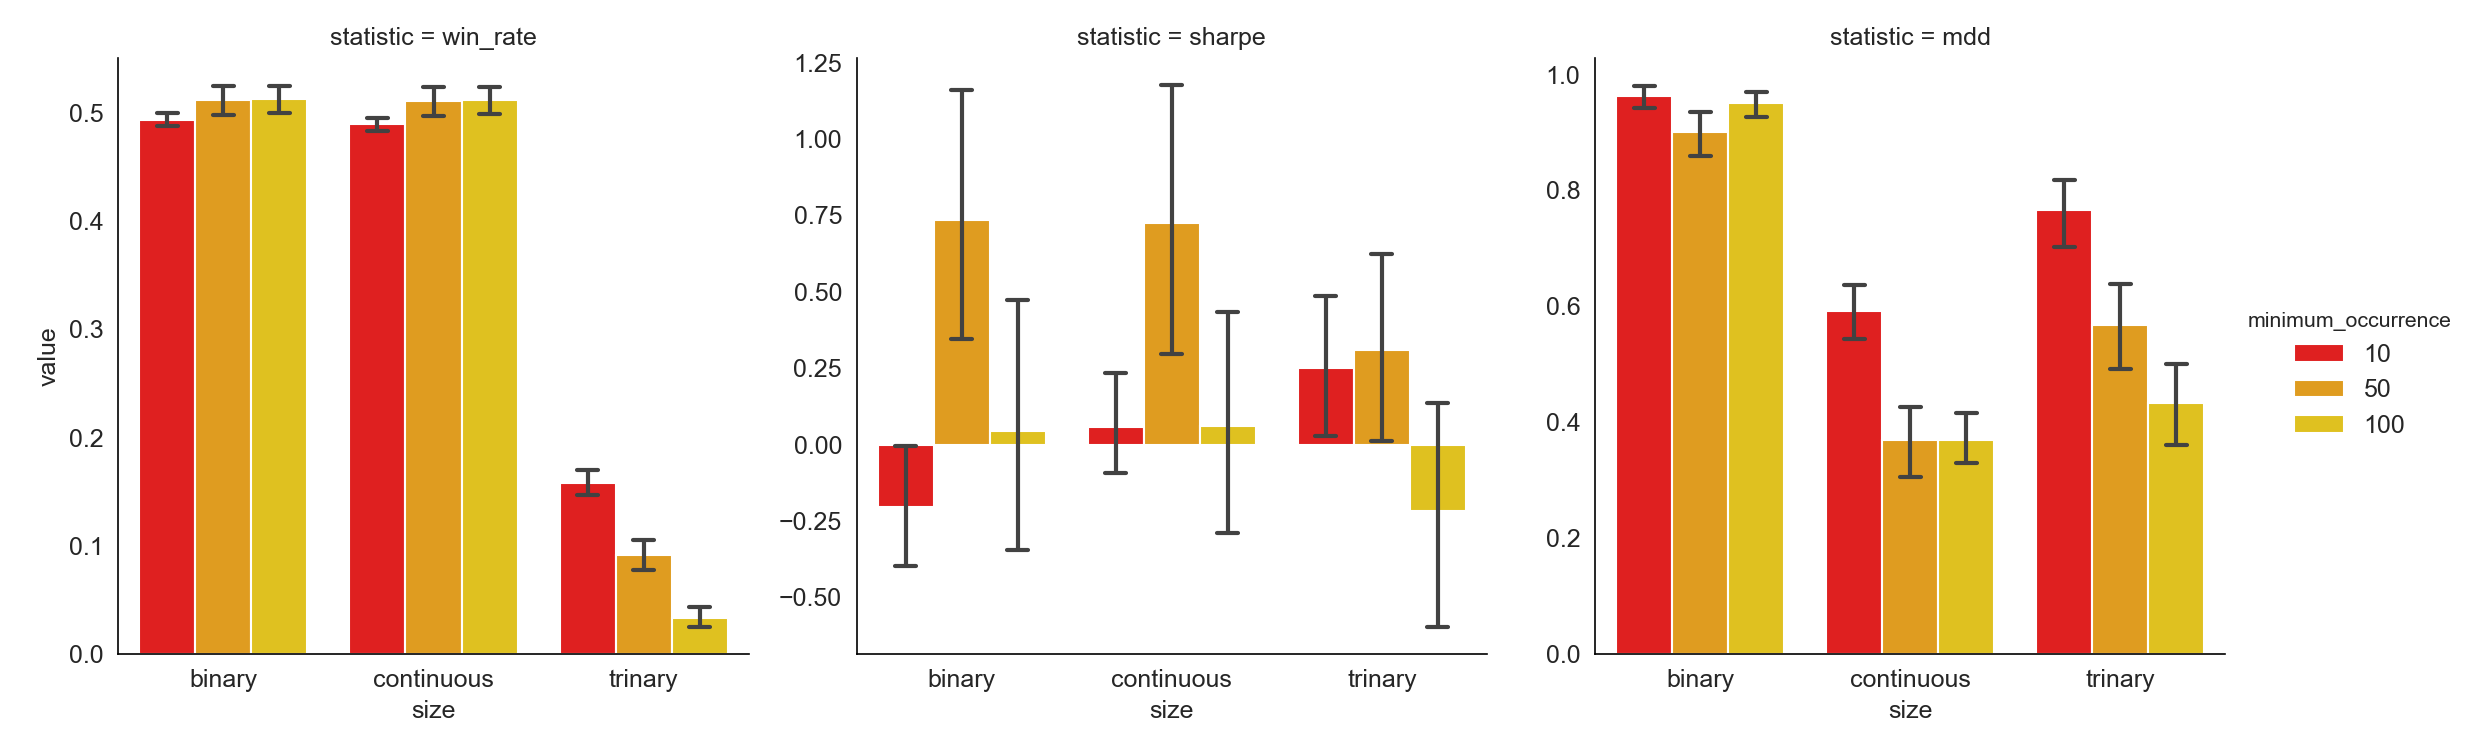

In [35]:
Image('misc/minimum_occurrence.png')

Higher minimum occurrence implies a stricter constraint on selecting sentiment-charged words. While noises coming from words which do not show up frequently are diminished, if minimum occurrence is set too high, some useful information is left out. Moreover, a very small pool of sentiment-charged words will cause the training and predicting to be extremely hard and even impossible.

From the results, we can conclude that setting minimum occurrence equal to 50 generates better Sharpe Ratio and Maximum Drawdown than setting it to 10 or 100. 


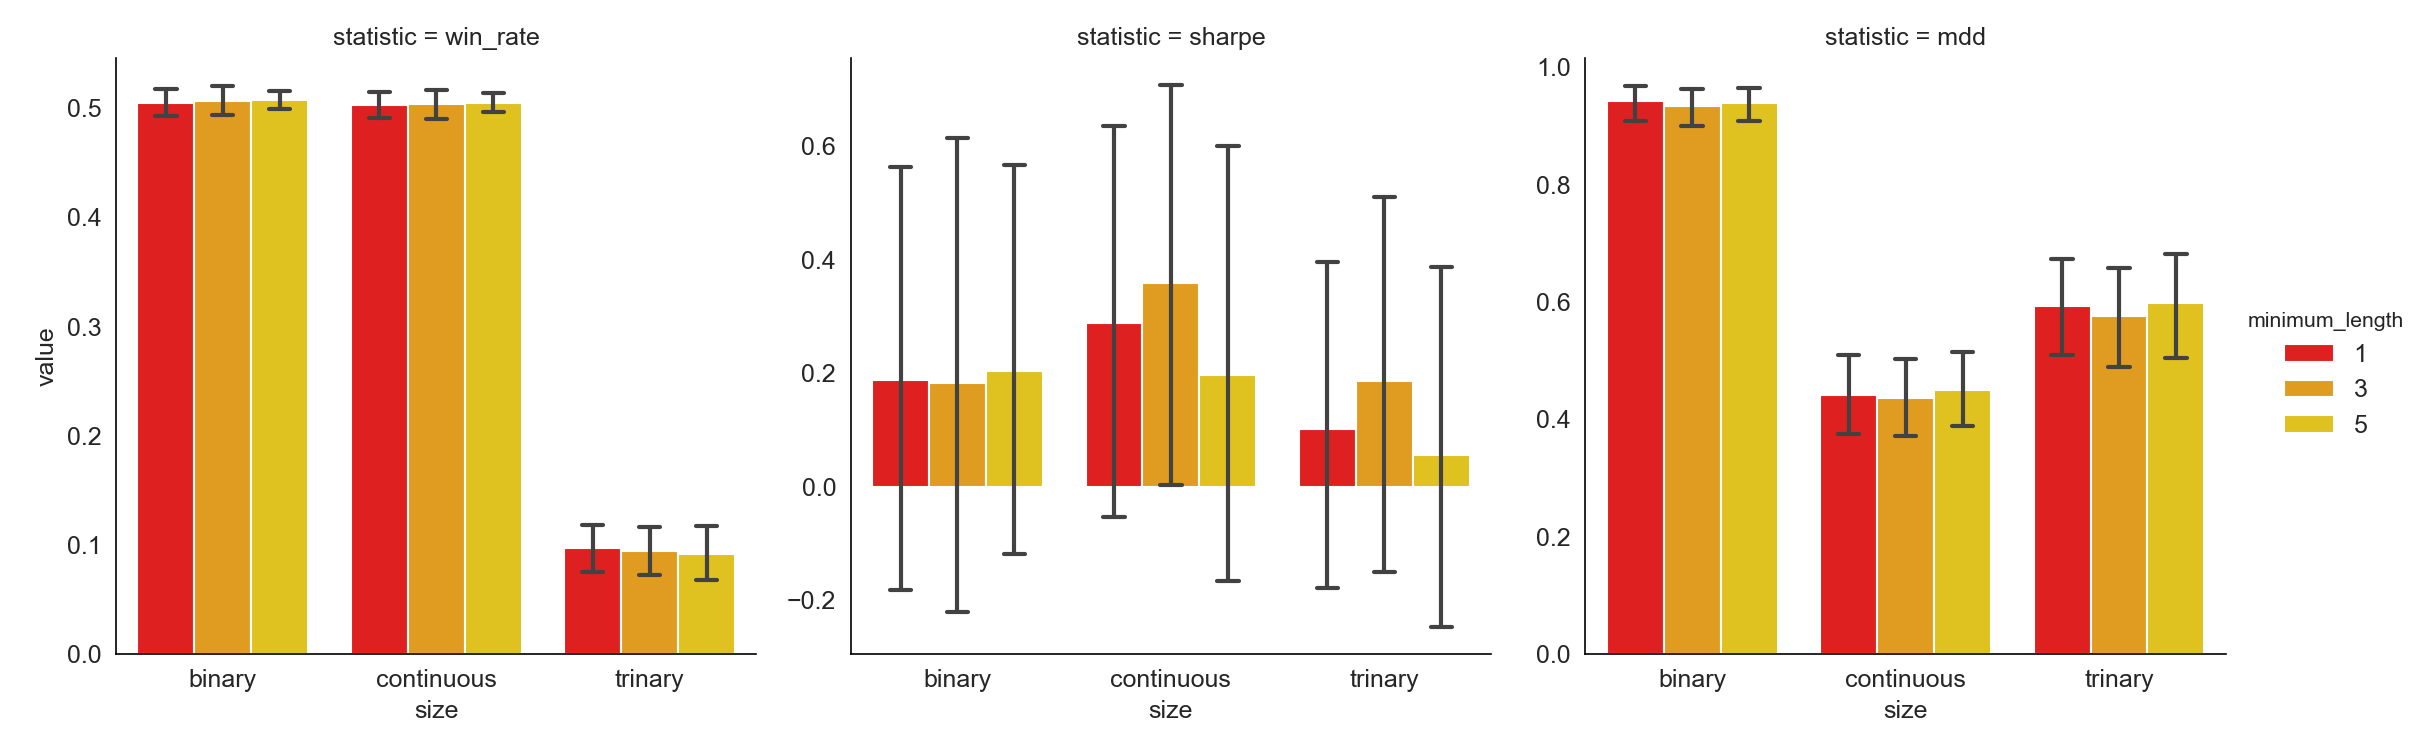

In [36]:
Image('misc/minimum_length.png')

Many of the short words, those whose lengths are 2 or 3, are not really informative, thus conveying nearly no sentiment. For instance, words such as "a", "is", and "the" show up in almost every piece of news multiple times. Whereas they do't offer much help in understanding the sentiment of the news, so they can be eliminated without hurting the results. Of course, this simple criterion is arbitrary, thus needs to be tested. Based on the results we get, different minimum length values do't impact the strategy statistics significantly.

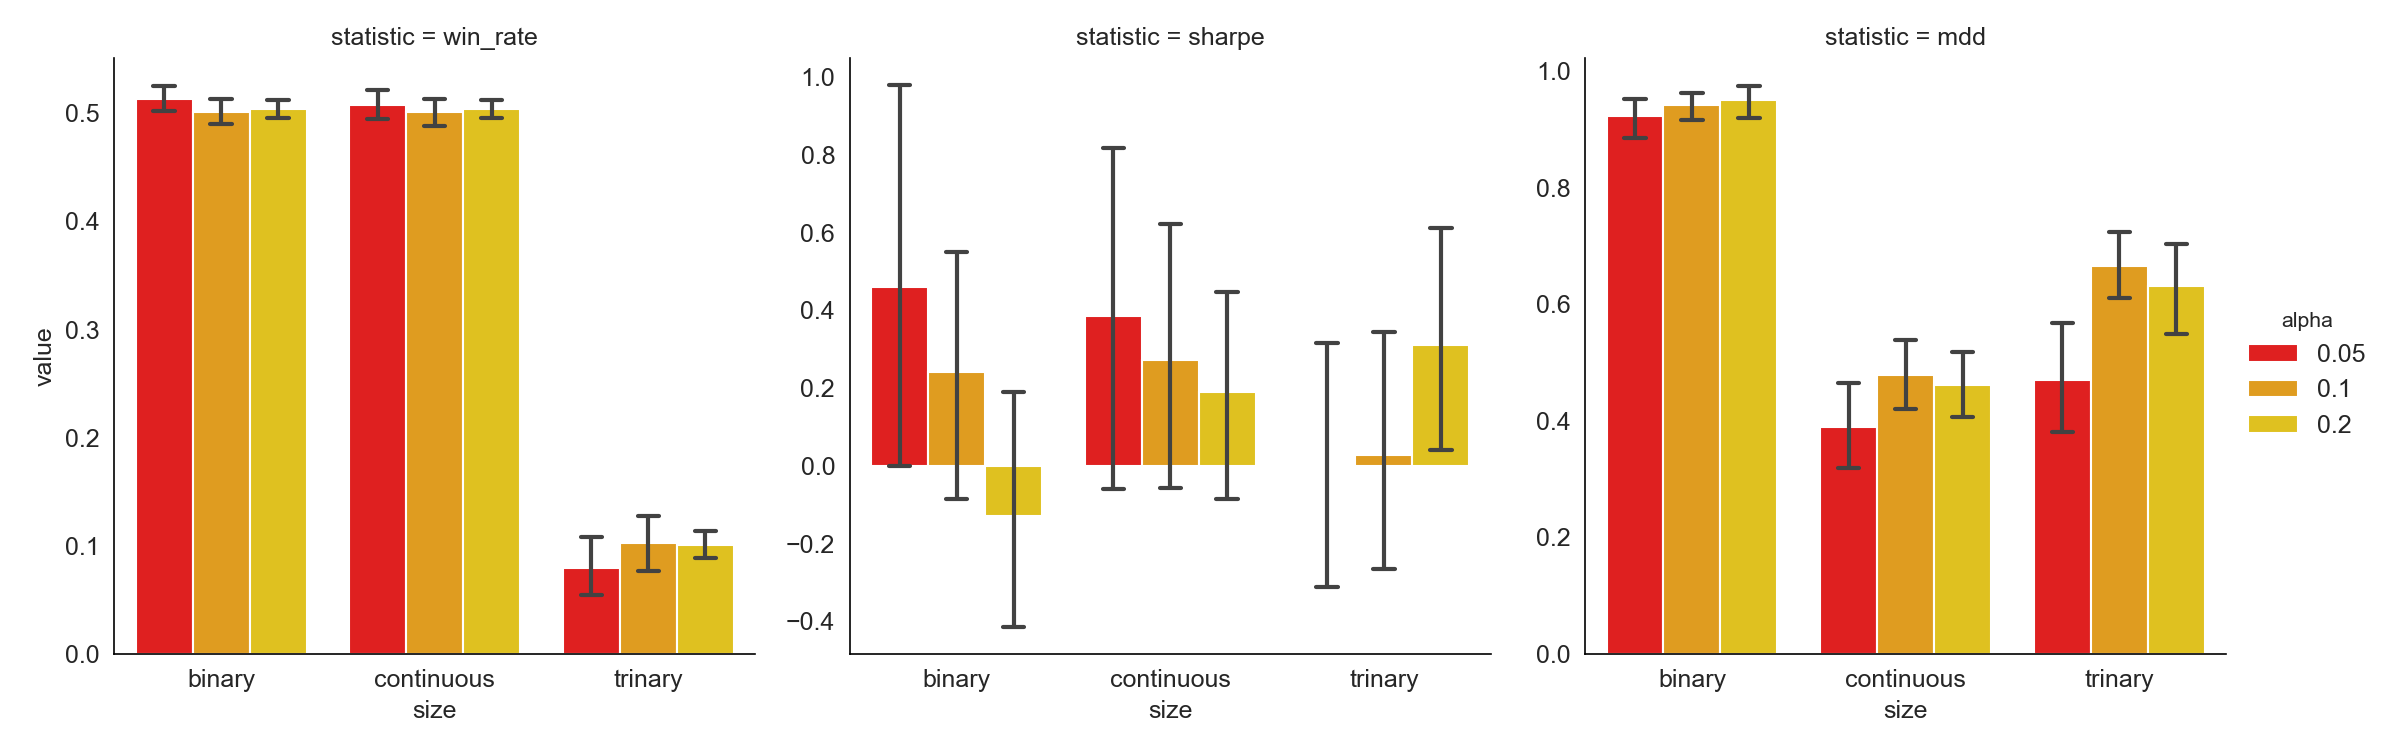

In [37]:
Image('misc/alpha.png')

Alpha is used to define the percentage of sentiment-charged words that are positive or negative. Similar to minimum occurrence, a strategy with a larger alpha includes more information into the analysis and vice versa. An alpha of 0.05 gives the best results as shown above.

**For sizing function:**
- Binary: if p is greater than 0.5, we take 1 long position; otherwise, we take 1 short position.
- Continuous: we always take 2p-1 positions, since p ranges from 0 to 1, 2p-1 ranges from -1 to 1.
- Trinary: if p is greater than ⅔, we take 1 long position in the portfolio; it p is less than ⅔ but greater than ⅓, we do't take any position; otherwise, we take 1 short position.

Trinary has much worse performance than binary and continuous as both Win rate and Sharpe ratio are worse for Trinary than for the other two.
While continuous and binary are similar on Win rate and Sharpe ratio, continuous always has smaller Maximum Drawdowns. Therefore, it is a more stable strategy and is thus best for risk-averse investors. 


For a more comprehensive practice of hyper-parameter exploration, we summarized the scripts above into a local module `backtest` for convenient backtesting. The general usage is summarized as below:

```py
from misc.backtest import BacktestEngine

be = BacktestEngine()
be.run(
    lookback_window=60,
    minimum_occurrence=50,
    minimum_length=5,
    alpha=.1,
    size=lambda x: 2 * x - 1
)
```

See [Appendix C](#ac)<a id='acback'></a> for the complete code and the detailed parameter testing outputs.

### Risk Management [↩](#riskback)<a id='risk'></a>
Momentum trading strategy is essentially buying on gainers and selling on losers. Due to the low liquidity and slow information dissemination nature of cryptocurrency trading, trading on momentum is, theoretically speaking, profitable. However, there is no guarantee that what makes gains will continue being profitable and what generates losses will keep losing money. Therefore, a risk management technique to prevent the strategy from taking huge amount of unexpected losses is a must-have with no doubt.

One of the most common approaches to controlling risks is to include a stop-loss feature. A usual way to apply a stop-loss is to calculate returns, determine if it falls below the threshold and then exit the position if it does. Here is where our strategy differs. It does not need an additional stop-loss as a stop-loss feature is embedded in the strategy already. The reason is that the underlying momentum strategy invests in a dynamic portfolio, meaning that all the positions the strategy enters on the previous day will be closed today no matter how the performance is on the previous day. In other words, the momentum strategy does not pick the same set of coins to invest from day to day, previous losses will not accumulate in following days. 

## Conclusion  [↩](#conback)<a id='con'></a>

In this research paper, we tested momentum and momentum reversal strategies in the cryptocurrency market and improved the traditional momentum strategy by introducing a brand-new sentiment-based model. The model significantly improved the general strategy scenario. It turned out that our hybrid model can handle massive market collapses e.g. mid-2018 while taking valid non-zero positions, and can grasp profits at potential opportunities.

There are, however, still several limitations in this research. First, due to the limited history of cryptocurrency, our dataset is rather short compared with stock data, with only 2014 - 2019 making up both training and testing sets. This limitation does not only occur w.r.t. time, but also troubles us during dynamic coin selection. Since we need a long period of historical data, our choices of coins became considerably restricted (less than 20), which further causes us to hold less (to be precise, 6 in this case) coins at each day. Idiosyncratic risks may not be well diversified and there is non-negligible likelihood that our strategy fails us because of failure in one certain coin -- though luckily, we didn't encounter this issue.

Last but not least, more rigorous backtests could be implemented to perform against our strategies. We may use intra-day data, if possible, for better accuracy. Furthermore, we can take order book into account to cope with micro-structure related concerns. By and large, our hybrid strategy satisfyingly outperformed all benchmark strategies in the same market and we deem this as a strong and good result.

## References [↩](#refback)<a id='ref'></a>

- Chan, L. K., Jegadeesh, N., & Lakonishok, J. (1996). *Momentum strategies*. The Journal of Finance, 51(5), 1681-1713.

- Antonacci, Gary (2014). *Dual Momentum Investing: An Innovative Approach for Higher Returns with Lower Risk*. New York: McGraw-Hill Education, 13–18. [↩](#a2014back)<a id='a2014'></a>

- Rohrbach, J., Suremann, S., & Osterrieder, J. (2017). *Momentum and trend following trading strategies for currencies revisited-combining academia and industry.* [↩](#rso2017back)<a id='rso2017'></a>

- Ke, Z. T., Kelly, B. T., & Xiu, D. (2019). *Predicting Returns With Text Data. Available at SSRN.* [↩](#kkx2019back)<a id='kkx2019'></a>

- Caporale, G. M., & Plastun, O. (2018). *Price overreactions in the cryptocurrency market.* [↩](#cp2018back)<a id='cp2018'></a>

## Appendix [↩](#appback)<a id='app'></a>

We include all miscellaneous scripts (mostly for data crawling) as below.

### Appendix A: News Data [↩](#aaback)<a id='aa'></a>

```py
import time
import random
import requests
import pandas as pd
from bs4 import BeautifulSoup
from datetime import datetime as dt
from randomheaders import LoadHeader as random_header


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


random.seed(123)
COLUMNS = ['time', 'title']
INFO = pd.DataFrame(columns=COLUMNS)
IP_LIST = []


def get_proxy():
    return requests.get('http://localhost:5555/get/').text

def delete_proxy(proxy):
    requests.get(f'http://localhost:5555/delete/?proxy={proxy}')

def get_soup(url, parser):
    while True:
        try:
            time.sleep(random.uniform(0, 1))
            proxy = get_proxy()
            html = requests.get(
                url, timeout=(3, 7), headers=random_header(),
                proxies={'http': proxy, 'https': proxy}).text
            return BeautifulSoup(html, parser)
        except Exception:
            delete_proxy(proxy)

def parse_time(timestr):
    raw_time = timestr[10:].split('/')[0].replace('on', '')
    time = dt.strptime(raw_time, '%H:%M  %B %d, %Y  ')
    return time

def get_content(url):
    soup = get_soup(url, 'lxml')
    paragraphs = soup.select('div[class="entry-content"]')[0].select('p')
    content = '\n'.join([para.text for para in paragraphs[:-1]])
    return content

def get_posts(soup):
    if '404 - PAGE NOT FOUND' in soup.text: return None
    posts = soup.select('a[class="stream-article"]')
    titles, times, abstracts, contents = [], [], [], []
    for p in posts:
        meta = p.select('div[class="meta"]')[0]
        titles.append(meta.select('h3')[0].text)
        times.append(meta.select('time')[0]['datetime'])
        abstracts.append(meta.select('p')[0].text)
        contents.append(get_content(p['href']))
    posts = pd.DataFrame({'title': titles, 'abstract': abstracts, 'content': contents}, index=times)
    posts.index = pd.to_datetime(posts.index)
    return posts


all_posts = pd.DataFrame(columns=['title', 'abstract', 'content'])

i = 0
while True:
    try:
        i += 1
        print(f'Crawling page {i}: ', end='')
        url = f'https://www.coindesk.com/category/markets-news/page/{i}'
        soup = get_soup(url, 'lxml')
        posts = get_posts(soup)
        if posts is None: raise EOFError
        all_posts = pd.concat([all_posts, posts])
        print(f'finished ({posts.shape[0]} posts)')
    except IndexError:
        print('failed, retrying', end='\r')
        i -= 1
    except (EOFError, KeyboardInterrupt):
        print('terminated')
        print(f'Total number of posts crawled: {all_posts.shape[0]}')
        all_posts.to_csv('../data/posts.csv')
        exit()
```

### Appendix B: EOD Data [↩](#abback)<a id='ab'></a>

```py
import os
import json
import sys
import requests
from bs4 import BeautifulSoup
import pandas as pd
from _datetime import datetime, date, timedelta


def save_crypto_coins_history(i_rank_start=1, i_rank_end=10, i_coin_file_path='crypto_coins', i_from_date=None, i_to_date=None, i_min_volume=100000, i_coin_markets=[]):
    from_date, to_date = get_from_to_dates(i_from_date, i_to_date)
    rank_range_from_start = i_rank_end - i_rank_start + 1
    coins_ranking_dict = get_coins_current_ranking(i_rank_start, rank_range_from_start, i_min_volume)
    df_coins = pd.DataFrame([])
    for rank, coin in coins_ranking_dict.items():
        if is_coin_in_markets(coin, set(i_coin_markets)):
            df_coins = df_coins.append(get_coins_historical_data(rank, coin, from_date, to_date))
            write_df_to_csv(df_coins, i_coin_file_path + '.csv')


def get_coins_current_ranking(i_start, i_limit, i_min_volume):
    url_coin_list_json = 'https://api.coinmarketcap.com/v1/ticker/?start={}&limit={}'.format(i_start - 1, i_limit)
    page = requests.get(url_coin_list_json)
    json_file = json.loads(page.text)
    coins_dict = {}
    for k in json_file:
        if float(k['24h_volume_usd']) >= i_min_volume:
            coins_dict[k['rank']] = k['id']
    return coins_dict


def get_coins_historical_data(i_rank, i_coin, i_from_date, i_to_date):
    df_coin = get_specific_coin_historical_data(i_coin, i_from_date, i_to_date)
    df_coin['Coin'] = i_coin
    df_coin['Cur. Rank'] = i_rank
    df_coin = pd.concat([df_coin.iloc[:, 7:], df_coin.iloc[:, 0:7]], axis=1, join_axes=[df_coin.index])
    return df_coin


def get_specific_coin_historical_data(i_coin, i_from_date, i_to_date):
    currencies = "https://coinmarketcap.com/currencies/"
    currencies_end = '/historical-data/'
    dates = '?start={}&end={}'.format(i_from_date, i_to_date)
    url = currencies + i_coin + currencies_end + dates
    page = requests.get(url)
    soup = BeautifulSoup(page.text, 'html.parser')
    table = soup.find('table')
    data = {'Date': [], 'Open': [], 'High': [], 'Low': [], 'Close': [], 'Volume': [], 'Market Cap': []}
    try:
        rows = table.findAll('tr')[1:]
        for row in rows:
            cols = row.findAll('td')
            data['Date'].append(cols[0].string)
            data['Open'].append(cols[1].string)
            data['High'].append(cols[2].string)
            data['Low'].append(cols[3].string)
            data['Close'].append(cols[4].string)
            data['Volume'].append(cols[5].string)
            data['Market Cap'].append(cols[6].string)
        coin_data = pd.DataFrame(data)
    except AttributeError:
        print('input parameters not valid')
        sys.exit(13)
    return coin_data


def write_df_to_csv(i_df, i_file):
    try:
        i_df.to_csv(i_file)
    except IOError as e:
        print(e)
        sys.exit(13)


def get_from_to_dates(i_from_date, i_to_date):
    try:
        if i_from_date is None:
            from_date = str(date.today() + timedelta(days=-30))
        else:
            from_date = i_from_date
        from_date = datetime.strptime(from_date, '%Y-%m-%d').strftime('%Y%m%d')

        if i_to_date is None:
            to_date = str(date.today() + timedelta(days=-1))
        else:
            to_date = i_to_date
        to_date = datetime.strptime(to_date, '%Y-%m-%d').strftime('%Y%m%d')

        return from_date, to_date
    except ValueError as e:
        print(e)
        sys.exit(13)


def is_coin_in_markets(i_coin, i_coin_markets_to_search):
    coin_in_markets = False
    coin_markets_url = 'https://coinmarketcap.com/currencies/{}/#markets'.format(i_coin)
    if not i_coin_markets_to_search:
        coin_in_markets = True
    else:
        page = requests.get(coin_markets_url)
        soup = BeautifulSoup(page.text, 'html.parser')
        table = soup.find('table')
        rows = table.findAll('tr')[1:]
        markets = set()
        for row in rows:
            cols = row.findAll('td')
            if cols[1].text is not None:
                markets.add(cols[1].text.upper())

            for market in i_coin_markets_to_search:
                if market.upper() in markets:
                    coin_in_markets = True
                    break

    return coin_in_markets


if __name__ == '__main__':
    symbols = [
        ('ANC', 'anoncoin'),
        ('BTB', 'bitbar'),
        ('BTC', 'bitcoin'),
        ('DGC', 'digitalcoin'),
        ('DOGE', 'dogecoin'),
        ('FRC', 'freicoin'),
        ('FTC', 'feathercoin'),
        ('IXC', 'ixcoin'),
        ('LTC', 'litecoin'),
        ('MEC', 'megacoin'),
        ('MNC', 'mincoin'),
        ('NMC', 'namecoin'),
        ('NVC', 'novacoin'),
        ('NXT', 'nxt'),
        ('OMNI', 'omni'),
        ('PPC', 'peercoin'),
        ('QRK', 'quark'),
        ('WDC', 'worldcoin'),
        ('XPM', 'primecoin'),
        ('XRP', 'ripple'),
        ('ZET', 'zetacoin'),
    ]
    price = dict()
    mkcap = dict()
    for sym, i_coin in symbols:
        if not os.path.isfile(f'{i_coin}.csv'):
            try:
                print(f'Downloading {i_coin:>12}', end=': ')
                df = get_specific_coin_historical_data(i_coin, '20120101', '20190520')[::-1]
                print(df.Date.iloc[0], df.Date.iloc[-1])
                df.to_csv(f'{i_coin}.csv')
            except:
                print('failed')
                pass

    for sym, i_coin in symbols:
        print(f'Loading {i_coin:>12}', end=': ')
        df = pd.read_csv(f'{i_coin}.csv').set_index('Date')
        df.index = pd.to_datetime(df.index)
        print(df.index[0].date(), df.index[-1].date())
        price[sym] = df['Close']
        mkcap[sym] = df['Market Cap']

    def convert(x):
        s = str(x).replace(',', '')
        try:
            return float(s)
        except:
            if s == '-':
                return float('nan')

    price = pd.DataFrame(price).dropna().applymap(convert).fillna(method='ffill')
    price.index.name = None
    price.to_csv('../data/price.csv')

    mkcap = pd.DataFrame(mkcap).dropna().applymap(convert).fillna(method='ffill')
    mkcap.index.name = None
    mkcap.to_csv('../data/mkcap.csv')

    print('Task finished')
```

Now we starting generating new features from these posts. First let's take a look at the data.


### Appendix C: Backtest Engine and Hyper-Parameter Testing [↩](#acback)<a id='ac'></a>

In this section, we give the full code of our backtest engine as well as the full list of hyper-parameter testing results. The scripts for engine is as below.

```py
import numpy as np
import pandas as pd
from collections import Counter
from scipy.optimize import minimize
from wordcloud import STOPWORDS


class BacktestEngine:
    def __init__(self):
        df = pd.read_csv('data/posts.csv', index_col=0)
        df.index = pd.to_datetime(df.index).date
        df_eod = df.copy()
        df_eod['date'] = pd.to_datetime(df_eod.index).date
        g = df_eod.groupby('date')
        title = g.title.apply(' '.join)
        abstract = g.abstract.apply(' '.join)
        content = g.content.apply(lambda x: '\n\n'.join(map(str, x.values)))
        df_eod = pd.concat([title, abstract, content], axis=1)
        df_eod.index = pd.to_datetime(df_eod.index)
        df_eod.index.name = None
        df_eod.title = df_eod.title.str.lower()
        df_eod.abstract = df_eod.abstract.str.lower()
        df_eod.content = df_eod.content.str.lower()
        remove_abbr = lambda x: ' '.join([_.split('’')[0] for _ in x.split()])
        df_eod = df_eod.applymap(remove_abbr)
        alph_space = lambda x: (ord('a') <= ord(x) <= ord('z')) or x == ' '
        keep_alph = lambda x: ''.join(filter(alph_space, x))
        df_eod = df_eod.applymap(keep_alph)
        replace_stop_words = lambda x: ' '.join(_ for _ in x.split() if _ not in STOPWORDS)
        df_eod = df_eod.applymap(replace_stop_words)
        df_eod = df_eod.applymap(str.split).applymap(sorted)
        price = pd.read_csv('data/price.csv', index_col=0)
        price.index = pd.to_datetime(price.index)
        mkcap = pd.read_csv('data/mkcap.csv', index_col=0)
        mkcap.index = pd.to_datetime(mkcap.index)
        self.data = (price, mkcap, df_eod)  # store data for later usage

    def run(self, lookback_window=60, minimum_occurrence=50, minimum_length=5, alpha=.1, size=lambda x: 2 * x - 1):
        n = 3  # number of coins to hold (long/short)
        d = lookback_window  # number of days to train
        price, mkcap, df_eod = self.data  # data stored for training (reusable)

        rtn = price.pct_change().fillna(0)
        rtn.index.name = None
        temp = (rtn * (mkcap.agg('argsort') < 10)).rolling(d).sum().T
        coins = pd.DataFrame(
            [temp.nlargest(n, t).index.tolist() + temp.nsmallest(n, t).index.tolist() for t in rtn.index],
            index=rtn.index).shift().dropna()  # shift to avoid forward-looking bias

        coef = np.array([1] * n + [-1] * n) / n
        rtn = pd.DataFrame([rtn.loc[t, coins.loc[t].values] @ coef for t in coins.index], index=coins.index)[0]
        rtn.name = 'r'

        df_total = df_eod[['content']].join(rtn, how='inner').dropna()
        df_total['p'] = np.argsort(df_total.iloc[:, 1]) / (df_total.shape[0] - 1)
        df_total.columns = ['words', 'r', 'p']

        test_split = 0.3
        len_total = len(df_total)
        len_test = round(len_total * test_split)
        len_train = len_total - len_test

        df_train = df_total.iloc[:len_train, :]
        df_test = df_total.iloc[-len_test:, :]

        words_all = sorted(list(set(w for words in df_train.words for w in words)))
        words_dict = {w: [] for w in words_all}

        for i in range(df_train.shape[0]):
            words, r, _ = df_train.iloc[i]
            for w in words: words_dict[w].append(r > 0)

        words_df = pd.DataFrame({
            'word': words_all,
            'r': [np.mean(words_dict[w]) for w in words_all],
            'k': [len(words_dict[w]) for w in words_all]
        }, index=range(len(words_all))).sort_values(by='r')

        words_df = words_df[words_df.k >= minimum_occurrence][words_df.word.apply(len) >= minimum_length].reset_index(drop=True)
        words_df['p'] = np.argsort(words_df.r) / (len(words_df) - 1)

        pos_words = words_df[words_df.p > 1 - alpha].word.values.tolist()
        neg_words = words_df[words_df.p < alpha].word.values.tolist()

        keywords = pos_words + neg_words

        def count_words(words):
            c = Counter(words)
            d = [c[w] for w in keywords]
            return np.array(d)

        df_train['d'] = df_train.words.apply(count_words).values

        p = df_train.p.values
        W = np.vstack([p, 1 - p]).T
        D = np.vstack(df_train.d.values)
        D = (D.T / D.sum(axis=1)).T
        D[np.isnan(D)] = 0
        O_pos, O_neg = np.maximum(np.linalg.pinv(W.T @ W) @ (W.T @ D), 0)
        O_pos = (O_pos / O_pos.sum())
        O_neg = (O_neg / O_neg.sum())

        def pen_ll(p, d, lamda):
            return (d * np.log(p * O_pos + (1 - p) * O_neg)).sum() + lamda * np.log(p * (1 - p))

        def predict(d, lamda):
            return minimize(lambda p: -pen_ll(p, d, lamda), x0=.5, method='Nelder-Mead').x[0]

        def mse_p(lamda):
            p_hat = np.array([predict(d, lamda) for d in df_train.d])
            return ((df_train.p.values - p_hat)**2).mean()

        best_lamda = minimize(mse_p, x0=0, method='Nelder-Mead', bounds=(0, None)).x[0]

        df_test['d'] = df_test.words.apply(count_words).values
        df_test['p_hat'] = [predict(d, best_lamda) for d in df_test.d]
        df_test = df_test[['words', 'r', 'p', 'p_hat', 'd']]

        compound = lambda x: (1 + x).cumprod() - 1

        r = df_test.r
        size = df_test.p_hat.apply(size)

        daily_rtn = r * size
        cum_rtn = compound(daily_rtn)
        daily_rtn_momentum = rtn[cum_rtn.index]
        cum_rtn_momentum = compound(daily_rtn_momentum)
        daily_rtn_momentum_rev = -daily_rtn_momentum
        cum_rtn_momentum_rev = compound(daily_rtn_momentum_rev)
        daily_rtn_buy_hold = price.BTC.pct_change().loc[cum_rtn.index]
        cum_rtn_buy_hold = compound(daily_rtn_buy_hold)

        win_rate = lambda x: (x > 0).mean()
        sharpe = lambda x: x.mean() / x.std() * np.sqrt(360)
        mdd = lambda x: (1 - x / x.cummax()).max()

        DAILY = [daily_rtn_buy_hold, daily_rtn_momentum, daily_rtn_momentum_rev, daily_rtn]
        CUM = [cum_rtn_buy_hold, cum_rtn_momentum, cum_rtn_momentum_rev, cum_rtn]
        wr = [win_rate(x) for x in DAILY]
        sr = [sharpe(x) for x in DAILY]
        md = [mdd(x + 1) for x in CUM]
        result = pd.DataFrame({'Win%': wr, 'Sharpe': sr, 'MDD': md}, index=['Buy & Hold', 'Momentum', 'Mom. Rev.', 'Strategy'])
        result.index.name = 'Statistics'

        return result
```

The hyper-parameter testing, using the backtest engine above, is listed as follows.

In [38]:
if not os.path.isfile('misc/results.csv'):
    from misc.backtest import BacktestEngine
    
    be = BacktestEngine()
    
    size_continuous = lambda x: 2 * x - 1
    size_binary = lambda x: 1 if x > .5 else -1
    size_trinary = lambda x: 1 if x > 2 / 3 else 0 if x > 1 / 3 else -1
    size_funcs = {
        'continuous': size_continuous,
        'binary': size_binary,
        'trinary': size_trinary
    }
    
    params = dict(
        lookback_window=[20, 60, 120],
        minimum_occurrence=[10, 50, 100],
        minimum_length=[1, 3, 5],
        alpha=[.05, .10, .20],
        size=['continuous', 'binary', 'trinary']
    )
    
    def grid(g):
        keys, values = zip(*g.items())
        for v in product(*values):
            yield dict(zip(keys, v))
    
    P = namedtuple('Params', params.keys())
    
    results = {}
    print('Initializing...', end='\r')
    for i, param in enumerate(grid(params)):
        p = P(**param)
        param['size'] = size_funcs[param['size']]
        result = be.run(**param)
        results[p] = result
        wr, sr, md = result.T.Strategy
        print(f'[{(i + 1):>3d}] {p}:\n      Win%={wr:.2%}, Sharpe={sr:.2f}, MDD={md:.2%}')
    
    df_results = pd.concat(results).reset_index()
    df_results.columns = ['lookback_window', 'minimum_occurrence', 'minimum_length',
                          'alpha', 'size', 'strategy', 'win_rate', 'sharpe', 'mdd']
    df_results.to_csv('misc/results.csv')

else:
    df_results = pd.read_csv('misc/results.csv', index_col=0)


display(HTML(df_results.to_html(max_rows=10)))

In [39]:
df_results_strategy = df_results[df_results.strategy=='Strategy'].drop('strategy', axis=1).melt(
    id_vars=['lookback_window', 'minimum_occurrence', 'minimum_length', 'alpha', 'size'],
    value_vars=['win_rate', 'sharpe', 'mdd'], var_name='statistic'
)
display(HTML(df_results_strategy.to_html(max_rows=10)))

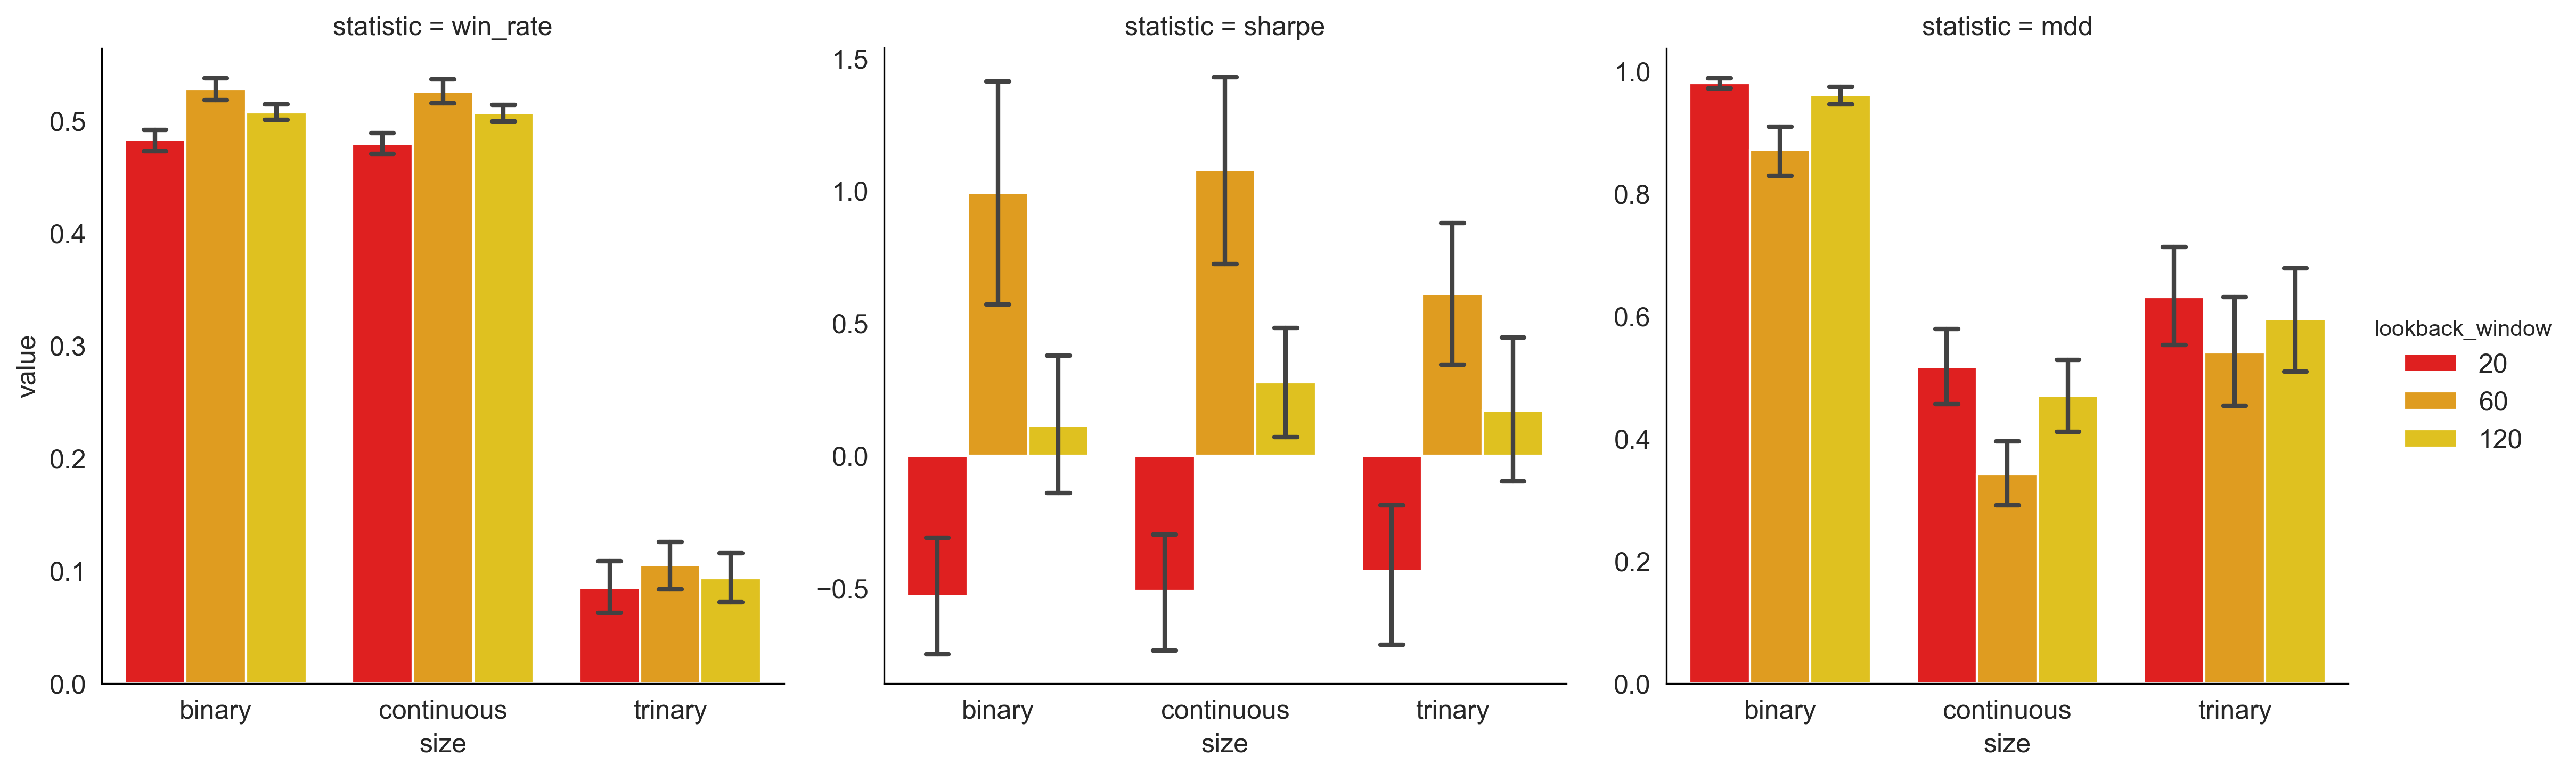

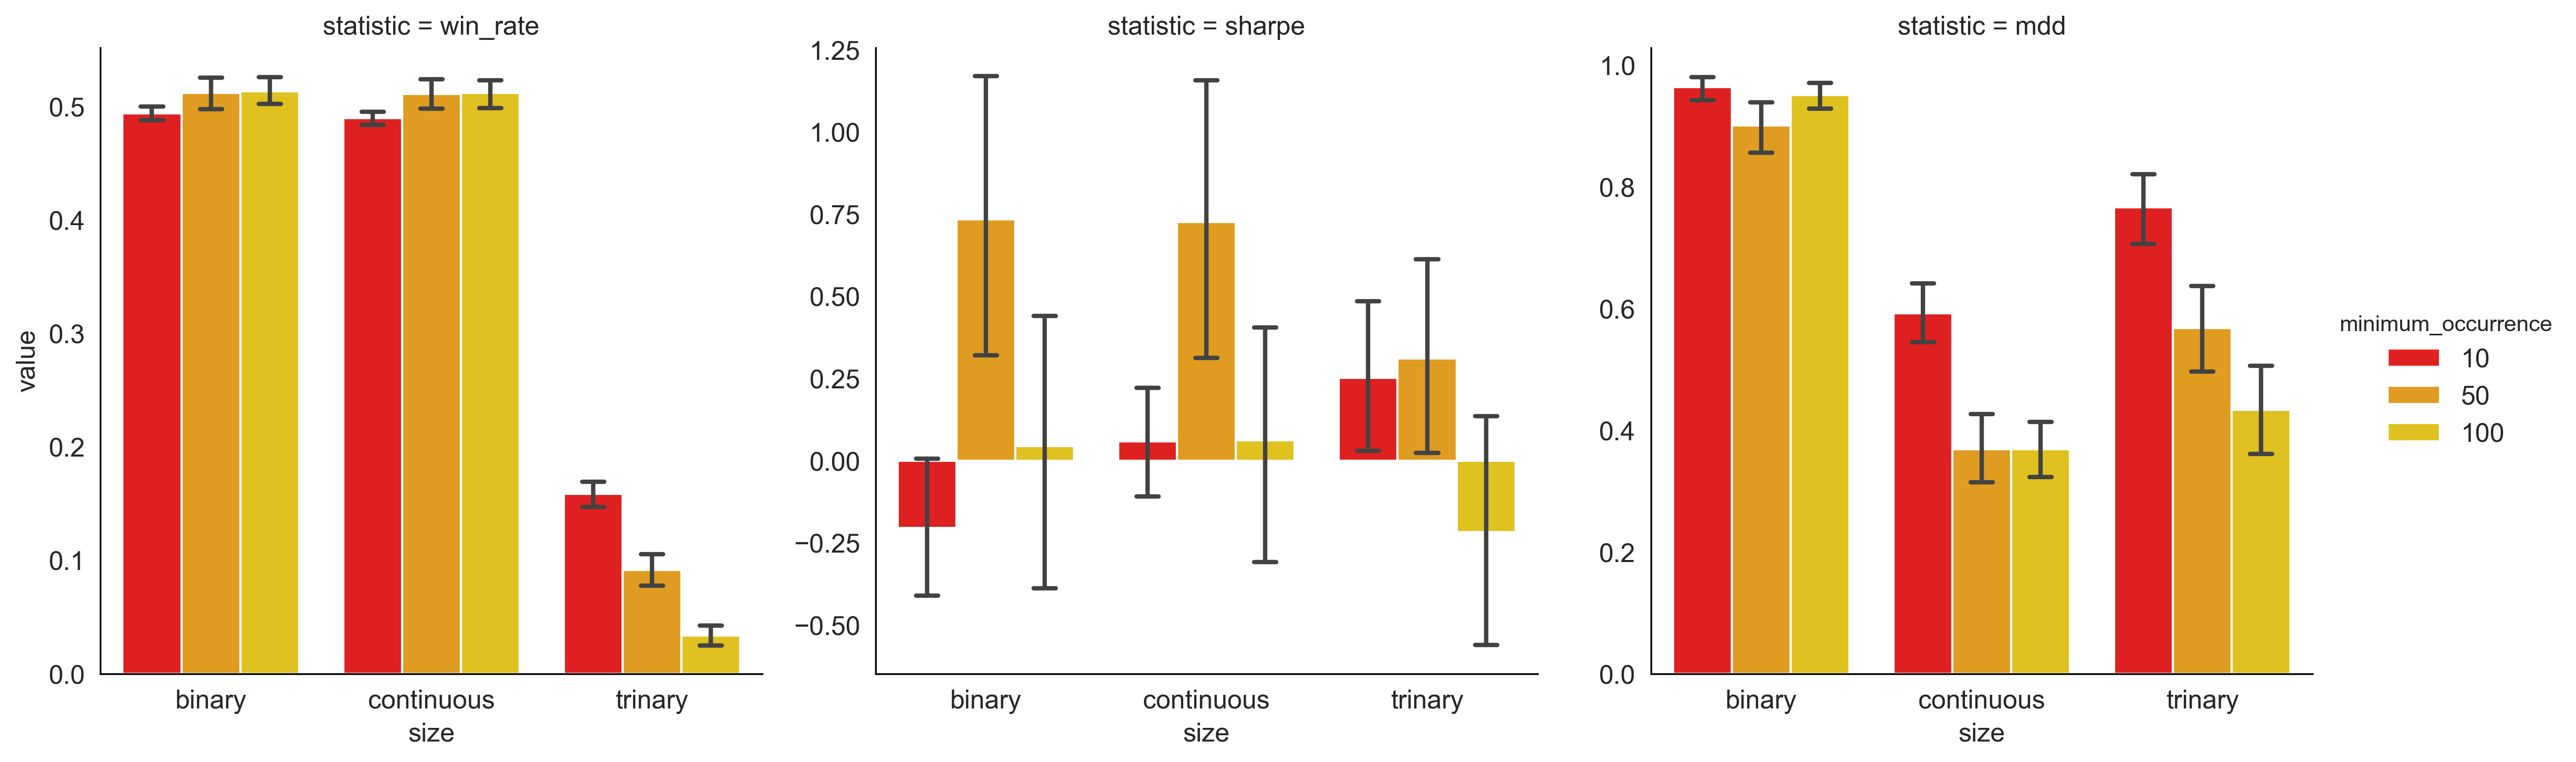

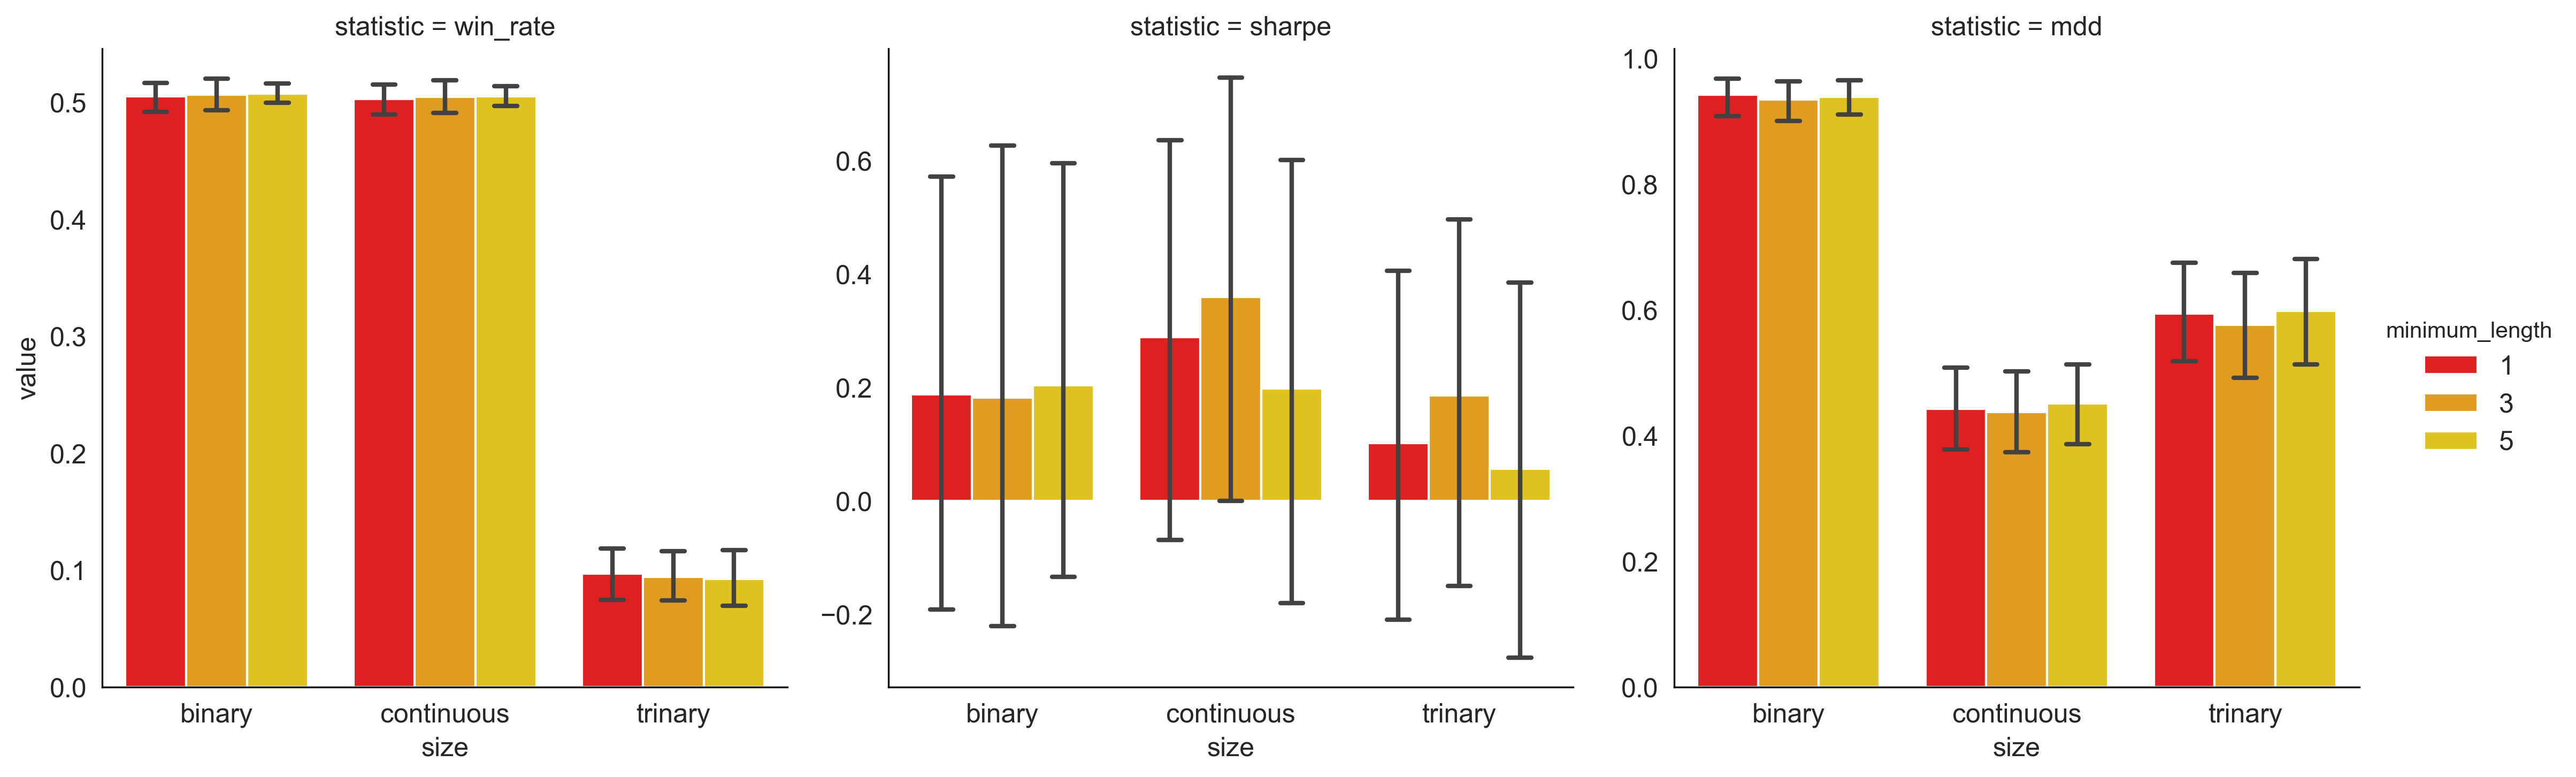

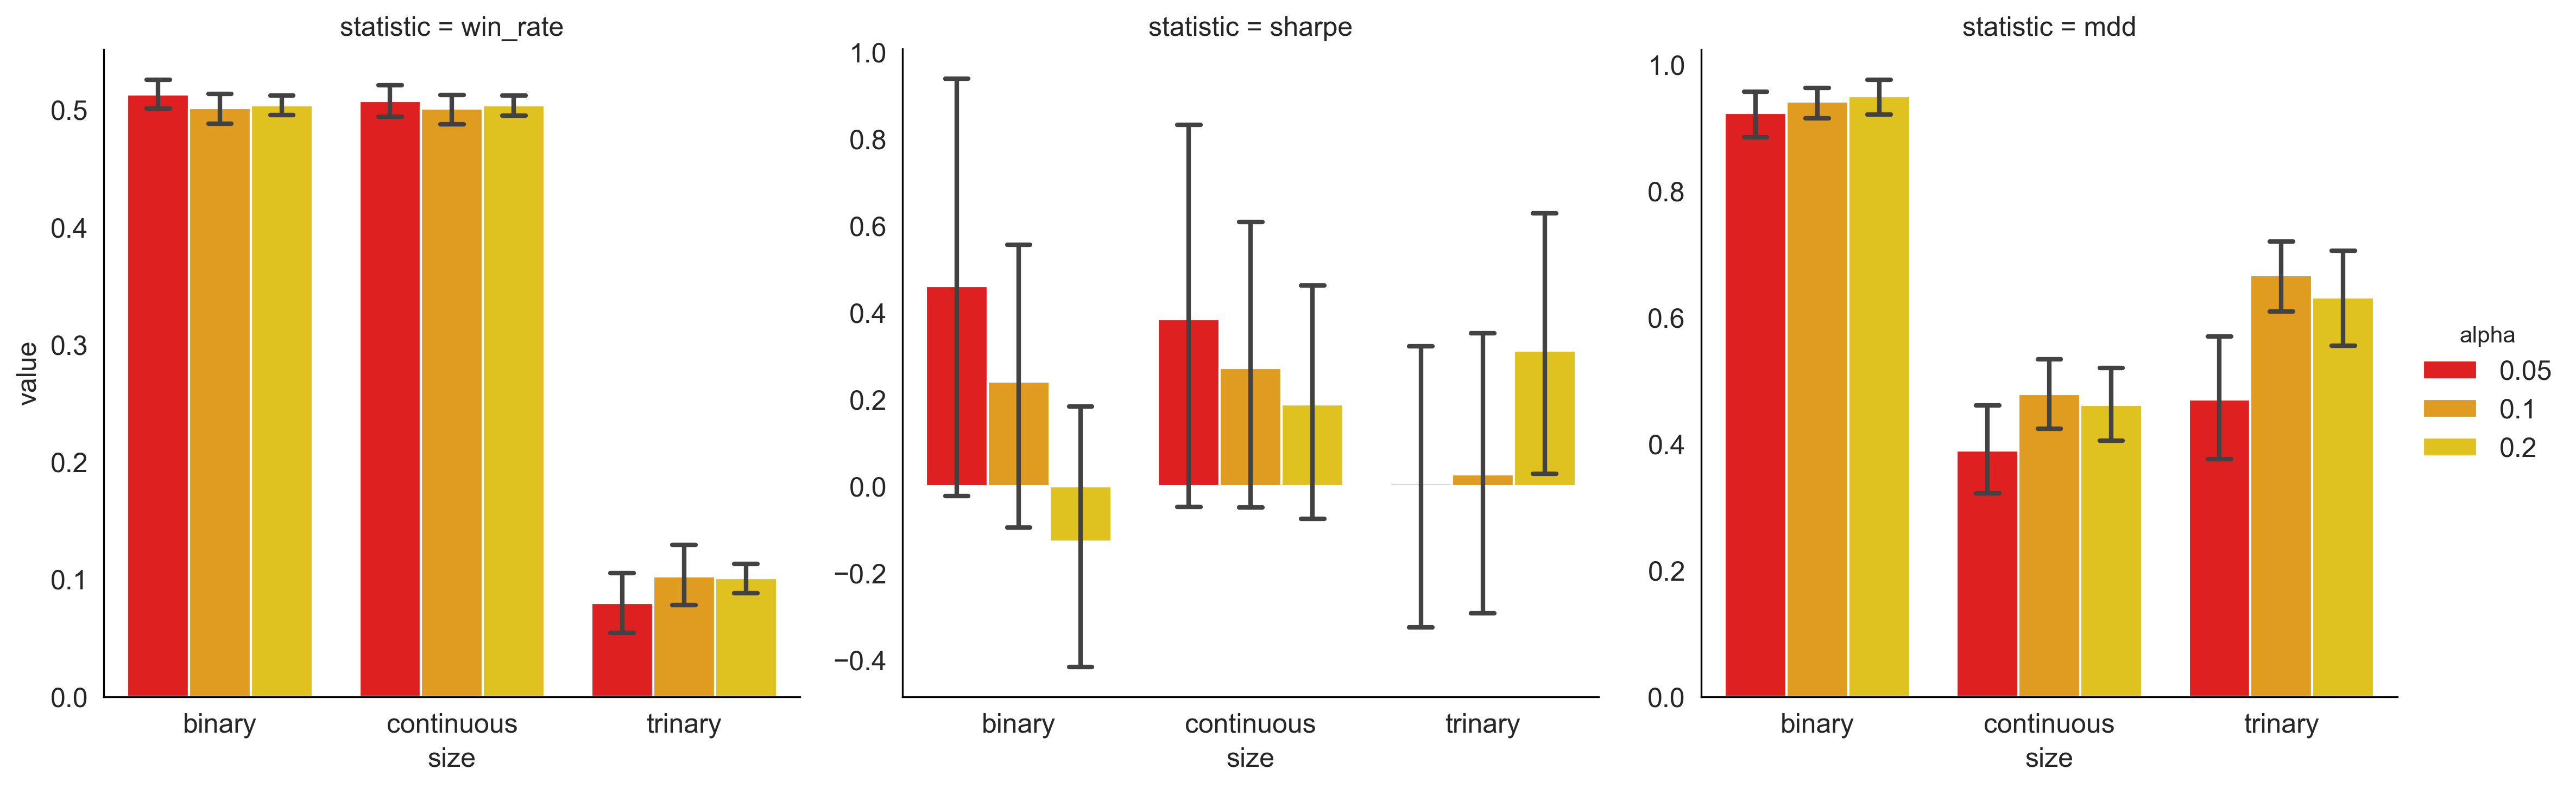

In [40]:
sns.set({
    'font.size': 12, 'axes.labelsize': 12, 'legend.fontsize': 12, 
    'axes.titlesize': 12, 'xtick.labelsize': 12, 'ytick.labelsize': 12
})
sns.set_style({'axes.facecolor': 'white', 'axes.edgecolor': 'black', 'axes.linewidth': 2})

for hue in ['lookback_window', 'minimum_occurrence', 'minimum_length', 'alpha']:
    sns.catplot(
        x='size', y='value', hue=hue, col='statistic', kind='bar', capsize=.1, errwidth=2,
        sharey=False, palette=['red', 'orange', 'gold'], data=df_results_strategy
    )
    plt.savefig(f'misc/{hue}.png')

In [41]:
%%html
<script>initialize();</script>Click <a href="javascript:code_toggle()">here</a> to toggle.